In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

import dataframe_image as dfi
from scipy.stats import ks_2samp

In [14]:
#DIR_list=['Ravi2/', 'Ravi3/', 'Ravi4/']
#pth_list=['Ravi2_orthomosaic_02mm.png', 'Ravi3_orthomosaic_clip_02mm.tif', 'Ravi4_orthomosaic_clip_02mm.tif']
head='/DATA/vito/data/'
def get_synth_ac(Ds, head):
    return [os.path.join(head+Ds, f) for f in os.listdir(head+Ds) if os.path.isfile(os.path.join(head+Ds, f))]
s02 = get_synth_ac('ran_synth_12_1500_shadow2_0_2/ran_synth_12_1500_shadow2_0_2', head)

In [15]:
s02

['/DATA/vito/data/ran_synth_12_1500_shadow2_0_2/ran_synth_12_1500_shadow2_0_2/point_based_ac_00.npy',
 '/DATA/vito/data/ran_synth_12_1500_shadow2_0_2/ran_synth_12_1500_shadow2_0_2/point_based_ac_11.npy',
 '/DATA/vito/data/ran_synth_12_1500_shadow2_0_2/ran_synth_12_1500_shadow2_0_2/point_based_ac_10.npy',
 '/DATA/vito/data/ran_synth_12_1500_shadow2_0_2/ran_synth_12_1500_shadow2_0_2/point_based_ac_01.npy',
 '/DATA/vito/data/ran_synth_12_1500_shadow2_0_2/ran_synth_12_1500_shadow2_0_2/point_based_ac_09.npy',
 '/DATA/vito/data/ran_synth_12_1500_shadow2_0_2/ran_synth_12_1500_shadow2_0_2/point_based_ac_06.npy',
 '/DATA/vito/data/ran_synth_12_1500_shadow2_0_2/ran_synth_12_1500_shadow2_0_2/point_based_ac_03.npy',
 '/DATA/vito/data/ran_synth_12_1500_shadow2_0_2/ran_synth_12_1500_shadow2_0_2/point_based_ac_07.npy',
 '/DATA/vito/data/ran_synth_12_1500_shadow2_0_2/ran_synth_12_1500_shadow2_0_2/point_based_ac_05.npy',
 '/DATA/vito/data/ran_synth_12_1500_shadow2_0_2/ran_synth_12_1500_shadow2_0_2/poin

In [16]:
def iou_vs_area(DS_pths,c, handles, label):
    for pth in DS_pths:
        ran=np.load(pth, allow_pickle=True)
        iou_bysize = []
        for i in range(len(ran.item().get('iou'))):
            iou = np.mean(np.abs(ran.item().get('iou')[i:]))
            iou_bysize.append(iou)
        iou_bysize = np.array(iou_bysize)
        plt.plot(ran.item().get('area'), iou_bysize,color=c, alpha=0.5)
    handles.append(plt.Line2D([0], [0], color=c, label=label, alpha=0.5))
    return handles

def iou_scatter(DS_pths,c, handles, label):
    for pth in DS_pths:
        ran=np.load(pth, allow_pickle=True)
        plt.scatter(ran.item().get('area'), np.abs(ran.item().get('iou')),color=c, label=f'{pth[-6:-4]}', alpha=0.5)
    handles.append(plt.Line2D([0], [0], marker='o', linestyle='None', color=c, label=label, alpha=0.5))
    return handles

def f1_vs_area(DS_pths,c, handles, label):
    for pth in DS_pths:
        ran=np.load(pth, allow_pickle=True)
        f1_bysize = []

        for i in range(len(ran.item().get('point based'))):
            ac_class, count = np.unique(ran.item().get('point based')[i:], return_counts=True)
            TP_count = count[ac_class == 1][0] if 1 in ac_class else 0
            FN_count = count[ac_class == 0][0] if 0 in ac_class else 0
            if np.any(ac_class > 1):
                TP_count += np.sum(count[ac_class > 1])
                FP_id_count = np.sum(count[ac_class > 1])
                FP_count = np.sum([ac_class[i]*count[i] for i in range(len(ac_class)) if ac_class[i]>1]) - FP_id_count
            else:
                FP_count = 0
            precision = TP_count / (TP_count + FP_count) if (TP_count + FP_count) > 0 else 0
            recall = TP_count / (TP_count + FN_count) if (TP_count + FN_count) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            f1_bysize.append(f1)
        f1_bysize = np.array(f1_bysize)
        plt.plot(ran.item().get('area'), f1_bysize,color=c, label=f'{pth[-6:-4]}', alpha=0.5)
    handles.append(plt.Line2D([0], [0], color=c, label=label, alpha=0.5))
    return handles

def f1_scatter(DS_pths,c, handles, label):
    for pth in DS_pths:
        ran=np.load(pth, allow_pickle=True)
        plt.scatter(ran.item().get('area'), ran.item().get('point based'),color=c, label=f'{pth[-6:-4]}', alpha=0.5)
    handles.append(plt.Line2D([0], [0], marker='o', linestyle='None', color=c, label=label, alpha=0.5))
    return handles

def ravi_f1_scatter(idx, handles, label, col, min_area=0):
    DIR = DIR_list[idx]
    pth = pth_list[idx]
    image = cv2.imread(pth)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = np.load(DIR + 'all_mask_third_pass_id.npy')
    mask = cv2.resize(mask.astype(np.uint16), image.shape[:-1][::-1], interpolation=cv2.INTER_NEAREST)
    
    ids, counts = np.unique(mask, return_counts=True)
    ids, counts = ids[1:], counts[1:]
    area = counts * (0.2 * 0.2)

    ids = ids[np.argsort(area)]
    area = np.sort(area)
    
    TP = pd.read_csv(DIR + 'SAM_Points_cleaned.csv')

    classified_id = np.zeros_like(ids)
    for i in range(len(TP)):
        c = TP.iloc[i][1:3].values
        classified_id[ids == mask[int(c[0] * 2), int(c[1] * 2)]] = 1

    FN_area = np.load(DIR + 'FN_area.npy')
    area = np.hstack([area, FN_area])
    classified_id = np.hstack([classified_id, np.ones_like(FN_area) * 2])
    classified_id = classified_id[np.argsort(area)]
    area = np.sort(area)
    plt.scatter(area[area>min_area], classified_id[area>min_area], color=col, label=f'{pth[-6:-4]}', alpha=0.5)
    handles.append(plt.Line2D([0], [0], marker='o', linestyle='None', color=col, label=label, alpha=0.5))
    return handles

def ravi_f1_vs_area(idx, handles, label, col, min_area=0):
    DIR = DIR_list[idx]
    pth = pth_list[idx]
    image = cv2.imread(pth)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = np.load(DIR + 'all_mask_third_pass_id.npy')
    mask = cv2.resize(mask.astype(np.uint16), image.shape[:-1][::-1], interpolation=cv2.INTER_NEAREST)
    
    ids, counts = np.unique(mask, return_counts=True)
    ids, counts = ids[1:], counts[1:]
    area = counts * (0.2 * 0.2)

    ids = ids[np.argsort(area)]
    area = np.sort(area)
    
    TP = pd.read_csv(DIR + 'SAM_Points_cleaned.csv')

    classified_id = np.zeros_like(ids)
    for i in range(len(TP)):
        c = TP.iloc[i][1:3].values
        classified_id[ids == mask[int(c[0] * 2), int(c[1] * 2)]] = 1

    FN_area = np.load(DIR + 'FN_area.npy')
    area = np.hstack([area, FN_area])
    classified_id = np.hstack([classified_id, np.ones_like(FN_area) * 2])
    classified_id = classified_id[np.argsort(area)]
    area = np.sort(area)

    f1_bysize = []
    for i in range(len(classified_id)):
        ac_class, count = np.unique(classified_id[i:], return_counts=True)
        TP_count = count[ac_class == 1][0] if 1 in ac_class else 0
        FP_count = count[ac_class == 0][0] if 0 in ac_class else 0
        FN_count = count[ac_class == 2][0] if 2 in ac_class else 0

        precision = TP_count / (TP_count + FP_count) if (TP_count + FP_count) > 0 else 0
        recall = TP_count / (TP_count + FN_count) if (TP_count + FN_count) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        f1_bysize.append(f1)

    f1_bysize = np.array(f1_bysize)

    plt.plot(area[area>min_area], f1_bysize[area>min_area], '-o', color=col, label=DIR[:-1], alpha=0.5)
    handles.append(plt.Line2D([0], [0], color=col, linestyle='-', marker='o', label=label, alpha=0.5))
    return handles
def subplot_setup(handles, title, xlabel, ylabel, logx=True):
    ax1 = plt.gca()
    ax2 = ax1.secondary_xaxis('top', functions=(lambda x: (np.sqrt(x / np.pi))/(0.2), lambda x: ((x*0.2)**2) * np.pi))
    ax2.set_xlabel('Radius (pixels)')

    plt.legend(handles=handles, loc='lower right')

    plt.grid()
    if logx:
        plt.xscale('log')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

def Ravis(func, handles):
    handles = func(0, handles, 'Ravi 2','#1f77b4', 200)
    handles = func(1, handles, 'Ravi 3','#ff7f0e', 200)
    handles = func(2, handles, 'Ravi 4','#2ca02c', 200)
    return handles

In [6]:
data = []
for DIR in ['Ravi2/','Ravi3/','Ravi4/']:
    all_positives=np.load(DIR+'centroids.npy').shape[0]
    TP=len(pd.read_csv(DIR+'SAM_Points_cleaned.csv'))
    FP=all_positives-TP
    FN=len(pd.read_csv(DIR+'Points_added.csv'))
    Precision=TP/(TP+FP)
    Recall=TP/(TP+FN)
    F1=2*Precision*Recall/(Precision+Recall)

    data.append({
        'Image': DIR[:-1],
        'SAM Positives': all_positives,
        'True Positives': TP,
        'False Positives': FP,
        'False Negatives': FN,
        'Precision': Precision,
        'Recall': Recall,
        'F1 Score': F1
    })
df = pd.DataFrame(data)
df


,Image,SAM Positives,True Positives,False Positives,False Negatives,Precision,Recall,F1 Score
0,Ravi2,974,826,148,27,0.848049,0.968347,0.904215
1,Ravi3,3232,3059,173,215,0.946473,0.934331,0.940363
2,Ravi4,1881,1797,84,113,0.955343,0.940838,0.948035


In [13]:
df_styled = df.style.background_gradient().format(precision=2)
dfi.export(df_styled, 'figure/ac_table_ravi.png',table_conversion = 'matplotlib')

In [17]:
def ks_DS(DS_pths, threshold=0):
    sizes=[]
    sizes_re=[]
    for pth in DS_pths:
        ran=np.load(pth, allow_pickle=True)
        sizes += list(ran.item().get('area'))
        sizes_re += list(ran.item().get('segment area'))
    
    sizes = np.sort(sizes)/(0.2*0.2)

    sizes_re = np.sort(sizes_re)

    if threshold!=0:
        threshold=np.pi*(threshold/2)**2
        sizes=sizes[sizes>threshold]
        sizes_re=sizes_re[sizes_re>threshold]
    if len(sizes)>0 and len(sizes_re)>0:
        ks=ks_2samp(sizes_re,sizes, method= 'exact', alternative='two-sided')
    else:
        ks=[np.nan,np.nan]
    return ks

In [20]:
data = []
for syn in [s02]:
    all_positives_T, TP_T, FP_T, FN_T, label_T = 0, 0, 0, 0, 0
    for pth in syn:
        ran=np.load(pth, allow_pickle=True)
        ac_class, count = np.unique(ran.item().get('point based'), return_counts=True)
        TP_count = np.sum(count[ac_class > 0]) if 1 in ac_class else 0
        FN_count = count[ac_class == 0][0] if 0 in ac_class else 0
        FP_count = ran.item().get('mask_count')-1-np.sum(count[ac_class>0])
        Label_count = ran.item().get('label_count')

        TP_T += TP_count
        FN_T += FN_count
        FP_T += FP_count
        label_T += Label_count
        all_positives_T += ran.item().get('mask_count')-1
    ks_test=ks_DS(syn)
    ks_test_25=ks_DS(syn,20)
    ks_test_30=ks_DS(syn,30)
    precision = TP_T / (TP_T + FP_T) if (TP_T + FP_T) > 0 else 0
    recall = TP_T / (TP_T + FN_T) if (TP_T + FN_T) > 0 else 0
    F1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    data.append({
        'Image': syn[0].split('\\')[0],
        'Label count': label_T,
        'SAM Positives': all_positives_T,
        'True Positives': TP_T,
        'False Positives': FP_T,
        'False Negatives': FN_T,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': F1,
        'Ks statistic':np.round(ks_test[0],2),
        'Ks p': np.round(ks_test[1],2),
        'Ks statistic t25':np.round(ks_test_25[0],2),
        'Ks p t25': np.round(ks_test_25[1],2),
        'Ks statistic t30':np.round(ks_test_30[0],2),
        'Ks p t30': np.round(ks_test_30[1],2)
    })

df = pd.DataFrame(data)
df

,Image,Label count,SAM Positives,True Positives,False Positives,False Negatives,Precision,Recall,F1 Score,Ks statistic,Ks p,Ks statistic t25,Ks p t25,Ks statistic t30,Ks p t30
0,/DATA/vito/data/ran_synth_12_1500_shadow2_0_2/...,28020,26530,25928,602,2092,0.977309,0.925339,0.950614,0.04,0.0,0.04,0.0,0.02,0.0


In [31]:
data = []
inclination=[50,60,70,80,50,60,70,80, 50,60,70,80]
azimuth=[0,0,0,0,90,90,90,90, 180,180,180,180]
for syn in [s02]:
    
    for pth in syn:
        all_positives_T, TP_T, FP_T, FN_T, label_T = 0, 0, 0, 0, 0
        ran=np.load(pth, allow_pickle=True)
        ac_class, count = np.unique(ran.item().get('point based'), return_counts=True)
        TP_count = np.sum(count[ac_class > 0]) if 1 in ac_class else 0
        FN_count = count[ac_class == 0][0] if 0 in ac_class else 0
        FP_count = ran.item().get('mask_count')-1-np.sum(count[ac_class>0])
        Label_count = ran.item().get('label_count')

        TP_T += TP_count
        FN_T += FN_count
        FP_T += FP_count
        label_T += Label_count
        all_positives_T += ran.item().get('mask_count')-1
        ks_test=ks_DS(syn)
        ks_test_25=ks_DS(syn,20)
        ks_test_30=ks_DS(syn,30)
        precision = TP_T / (TP_T + FP_T) if (TP_T + FP_T) > 0 else 0
        recall = TP_T / (TP_T + FN_T) if (TP_T + FN_T) > 0 else 0
        F1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        data.append({
            #'Image': pth.split('/')[-1],
            'Inclination': inclination[int(pth[-6:-4])],
            'Azimuth': azimuth[int(pth[-6:-4])],
            'Label count': label_T,
            'SAM Positives': all_positives_T,
            'True Positives': TP_T,
            'False Positives': FP_T,
            'False Negatives': FN_T,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': F1,
            'Ks statistic':np.round(ks_test[0],2),
            'Ks p': np.round(ks_test[1],2),
            'Ks statistic t25':np.round(ks_test_25[0],2),
            'Ks p t25': np.round(ks_test_25[1],2),
            'Ks statistic t30':np.round(ks_test_30[0],2),
            'Ks p t30': np.round(ks_test_30[1],2)
        })

df = pd.DataFrame(data)
df

,Inclination,Azimuth,Label count,SAM Positives,True Positives,False Positives,False Negatives,Precision,Recall,F1 Score,Ks statistic,Ks p,Ks statistic t25,Ks p t25,Ks statistic t30,Ks p t30
0,50,0,2335,2229,2176,53,159,0.976223,0.931906,0.953550,0.04,0.0,0.04,0.0,0.02,0.0
1,80,180,2335,2243,2172,71,163,0.968346,0.930193,0.948886,0.04,0.0,0.04,0.0,0.02,0.0
2,70,180,2335,2236,2179,57,156,0.974508,0.933191,0.953402,0.04,0.0,0.04,0.0,0.02,0.0
3,60,0,2335,2213,2173,40,162,0.981925,0.930621,0.955585,0.04,0.0,0.04,0.0,0.02,0.0
4,60,180,2335,2231,2168,63,167,0.971762,0.928480,0.949628,0.04,0.0,0.04,0.0,0.02,0.0
5,70,90,2335,2226,2169,57,166,0.974394,0.928908,0.951107,0.04,0.0,0.04,0.0,0.02,0.0
6,80,0,2335,2161,2095,66,240,0.969459,0.897216,0.931940,0.04,0.0,0.04,0.0,0.02,0.0
7,80,90,2335,2164,2164,0,171,1.000000,0.926767,0.961992,0.04,0.0,0.04,0.0,0.02,0.0
8,60,90,2335,2206,2159,47,176,0.978694,0.924625,0.950892,0.04,0.0,0.04,0.0,0.02,0.0
9,50,90,2335,2227,2153,74,182,0.966771,0.922056,0.943884,0.04,0.0,0.04,0.0,0.02,0.0


In [32]:
df_styled = df.style.background_gradient().format(precision=2)
df_styled
dfi.export(df_styled, '/DATA/vito/fig/shadow_ac_table.png',table_conversion = 'matplotlib')

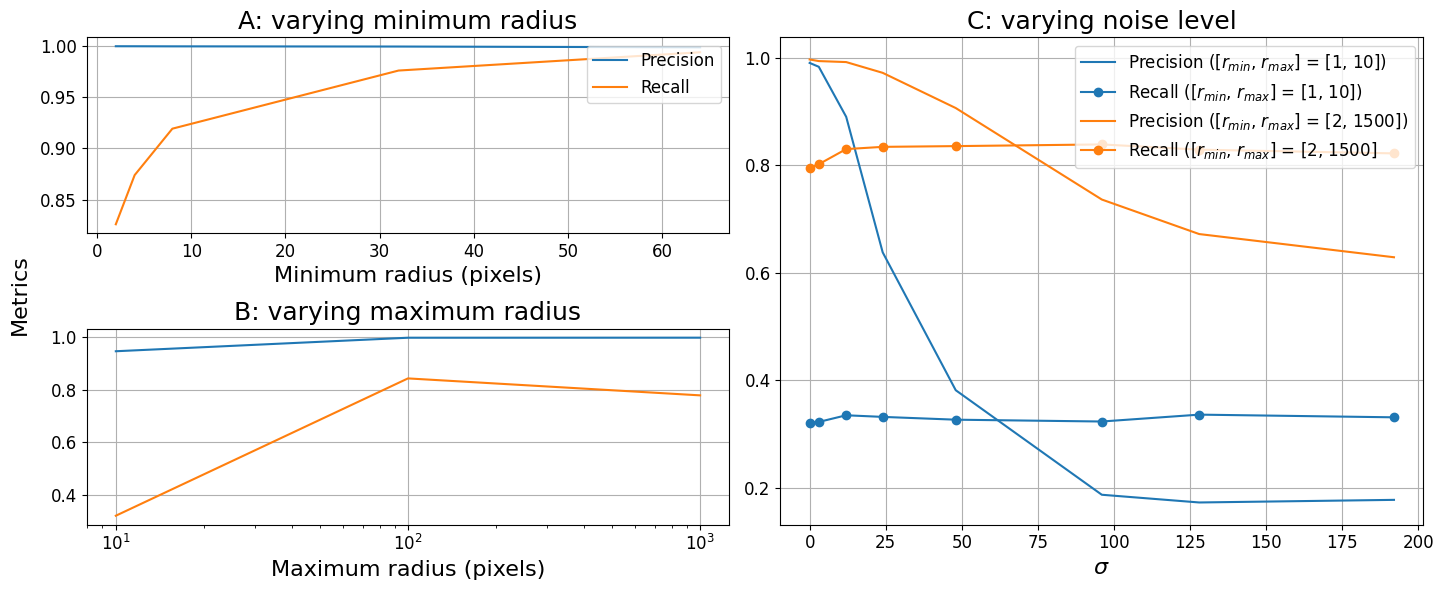

In [ ]:
Min_radi=[2,4,8,32,64]
plt.figure(figsize=(15, 6))
plt.subplot(2, 2, 1)
precision_L, recall_L = [], []
for syn in [rs02_3000, rs04_3000, rs08, rs32, rs64]:
    all_positives_T, TP_T, FP_T, FN_T = 0, 0, 0, 0
    for pth in syn:
        ran=np.load(pth, allow_pickle=True)
        ac_class, count = np.unique(ran.item().get('point based'), return_counts=True)
        TP_count = np.sum(count[ac_class > 0]) if 1 in ac_class else 0
        FN_count = count[ac_class == 0][0] if 0 in ac_class else 0
        FP_count = ran.item().get('mask_count')-np.sum(count[ac_class>0])

        TP_T += TP_count
        FN_T += FN_count
        FP_T += FP_count
        all_positives_T += ran.item().get('mask_count')

    precision=TP_T / (TP_T + FP_T) if (TP_T + FP_T) > 0 else 0
    recall=TP_T / (TP_T + FN_T) if (TP_T + FN_T) > 0 else 0
    precision_L.append(precision)
    recall_L.append(recall)
plt.plot(Min_radi, precision_L, label='Precision')
plt.plot(Min_radi, recall_L, label='Recall')
plt.legend(loc='upper right', fontsize=12)
plt.grid()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12) 
#plt.ylabel('Metrics', fontsize=16)
plt.xlabel('Minimum radius (pixels)', fontsize=16)
plt.title('A: varying minimum radius', fontsize=18)

plt.subplot(2, 2, 3)
Max_radi=[10,100,1000]
precision_L, recall_L = [], []
for syn in [rs01_10, rs01_100, rs01_1000]:
    all_positives_T, TP_T, FP_T, FN_T = 0, 0, 0, 0
    for pth in syn:
        ran=np.load(pth, allow_pickle=True)
        ac_class, count = np.unique(ran.item().get('point based'), return_counts=True)
        TP_count = np.sum(count[ac_class > 0]) if 1 in ac_class else 0
        FN_count = count[ac_class == 0][0] if 0 in ac_class else 0
        FP_count = ran.item().get('mask_count')-np.sum(count[ac_class>0])

        TP_T += TP_count
        FN_T += FN_count
        FP_T += FP_count
        all_positives_T += ran.item().get('mask_count')

    precision=TP_T / (TP_T + FP_T) if (TP_T + FP_T) > 0 else 0
    recall=TP_T / (TP_T + FN_T) if (TP_T + FN_T) > 0 else 0
    precision_L.append(precision)
    recall_L.append(recall)
plt.plot(Max_radi, precision_L,c='#1f77b4', label='Precision')
plt.plot(Max_radi, recall_L,c='#ff7f0e', label='Recall')
plt.xscale('log')
plt.grid()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12) 
plt.xlabel('Maximum radius (pixels)', fontsize=16)
plt.title('B: varying maximum radius', fontsize=18)


plt.subplot(1, 2, 2)
noise=[0,3,12,24,48,96,128,192]
precision_L, recall_L, F1_L = [], [], []
for syn in [cl00_10, cl03_10, cl12_10, cl24_10, cl48_10, cl96_10, cl128_10, cl192_10]:
    all_positives_T, TP_T, FP_T, FN_T = 0, 0, 0, 0
    for pth in syn:
        ran=np.load(pth, allow_pickle=True)
        ac_class, count = np.unique(ran.item().get('point based'), return_counts=True)
        TP_count = np.sum(count[ac_class > 0]) if 1 in ac_class else 0
        FN_count = count[ac_class == 0][0] if 0 in ac_class else 0
        FP_count = ran.item().get('mask_count')-np.sum(count[ac_class>0])

        TP_T += TP_count
        FN_T += FN_count
        FP_T += FP_count
        all_positives_T += ran.item().get('mask_count')

    precision=TP_T / (TP_T + FP_T) if (TP_T + FP_T) > 0 else 0
    recall=TP_T / (TP_T + FN_T) if (TP_T + FN_T) > 0 else 0
    precision_L.append(precision)
    recall_L.append(recall)
plt.plot(noise, precision_L,'-',c='#1f77b4', label=r'Precision ([$r_{min}$, $r_{max}$] = [1, 10])')
plt.plot(noise, recall_L,'o-',c='#1f77b4', label=r'Recall ([$r_{min}$, $r_{max}$] = [1, 10])')

precision_L, recall_L, F1_L = [], [], []
for syn in [cl00_02, cl03_02, cl12_02, cl24_02, cl48_02, cl96_02, cl128_02, cl192_02]:
    all_positives_T, TP_T, FP_T, FN_T = 0, 0, 0, 0
    for pth in syn:
        ran=np.load(pth, allow_pickle=True)
        ac_class, count = np.unique(ran.item().get('point based'), return_counts=True)
        TP_count = np.sum(count[ac_class > 0]) if 1 in ac_class else 0
        FN_count = count[ac_class == 0][0] if 0 in ac_class else 0
        FP_count = ran.item().get('mask_count')-np.sum(count[ac_class>0])

        TP_T += TP_count
        FN_T += FN_count
        FP_T += FP_count
        all_positives_T += ran.item().get('mask_count')

    precision=TP_T / (TP_T + FP_T) if (TP_T + FP_T) > 0 else 0
    recall=TP_T / (TP_T + FN_T) if (TP_T + FN_T) > 0 else 0
    precision_L.append(precision)
    recall_L.append(recall)
    F1_L.append( 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0)
plt.plot(noise, precision_L,'-',c='#ff7f0e', label=r'Precision ([$r_{min}$, $r_{max}$] = [2, 1500])')
plt.plot(noise, recall_L,'o-',c='#ff7f0e', label=r'Recall ([$r_{min}$, $r_{max}$] = [2, 1500]')
#plt.plot(noise, F1_L,'--', c='#2ca02c',label='F1 (Radius: 2-1500)')
plt.legend(loc='upper right', fontsize=12)
plt.grid()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12) 
plt.xlabel(r'$\sigma$', fontsize=16)
plt.title('C: varying noise level', fontsize=18)
plt.gcf().text(0.04, 0.5, 'Metrics', fontsize=16, rotation=90, va='center')
plt.tight_layout(rect=[0.05, 0, 1, 1])
plt.savefig('figure/ac_pr_synth.png')


C:\Users\Vito\AppData\Local\Temp\ipykernel_3800\2372240998.py:21: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if c<len(ac_class):


Text(0.5, 1.0, 'A: varying minimum radius')

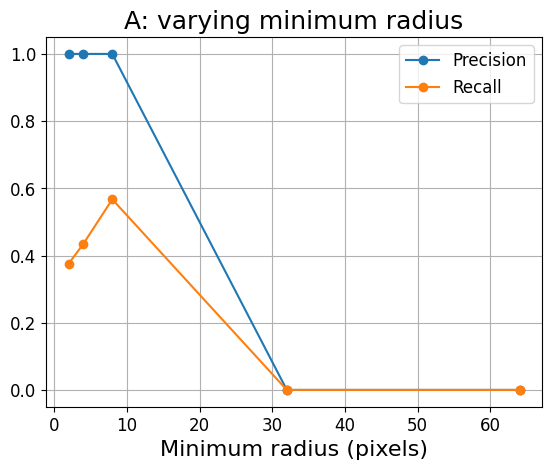

In [277]:
Min_radi=[2,4,8,32,64]
precision_L, recall_L = [], []
for syn in [rs02_3000, rs04_3000, rs08, rs32, rs64]:
    all_positives_T, TP_T, FP_T, FN_T = 0, 0, 0, 0
    for pth in syn:
        ran=np.load(pth, allow_pickle=True)

        area = np.array(ran.item().get('area'))
        area=(np.sqrt(area/np.pi)/0.2)*2
        ac = np.array(ran.item().get('point based'))

        ac=ac[area<20]
        area=area[area<20]

        ac_class, count = np.unique(ac, return_counts=True)
        
        TP_count = np.sum(count[ac_class > 0]) if 1 in ac_class else 0
        FN_count = count[ac_class == 0][0] if 0 in ac_class else 0
        multi=0
        for c in np.where(ac_class>1):
            if c<len(ac_class):
                multi+=(count[c]*ac_class[c]).item()
        FP_count = multi-np.sum(count[ac_class>1])

        TP_T += TP_count
        FN_T += FN_count
        FP_T += FP_count
        #all_positives_T += len(area)

    precision=TP_T / (TP_T + FP_T) if (TP_T + FP_T) > 0 else 0
    recall=TP_T / (TP_T + FN_T) if (TP_T + FN_T) > 0 else 0
    precision_L.append(precision)
    recall_L.append(recall)
plt.plot(Min_radi, precision_L,'o-', label='Precision')
plt.plot(Min_radi, recall_L,'o-', label='Recall')
plt.legend(loc='upper right', fontsize=12)
plt.grid()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12) 
#plt.ylabel('Metrics', fontsize=16)
plt.xlabel('Minimum radius (pixels)', fontsize=16)
plt.title('A: varying minimum radius', fontsize=18)

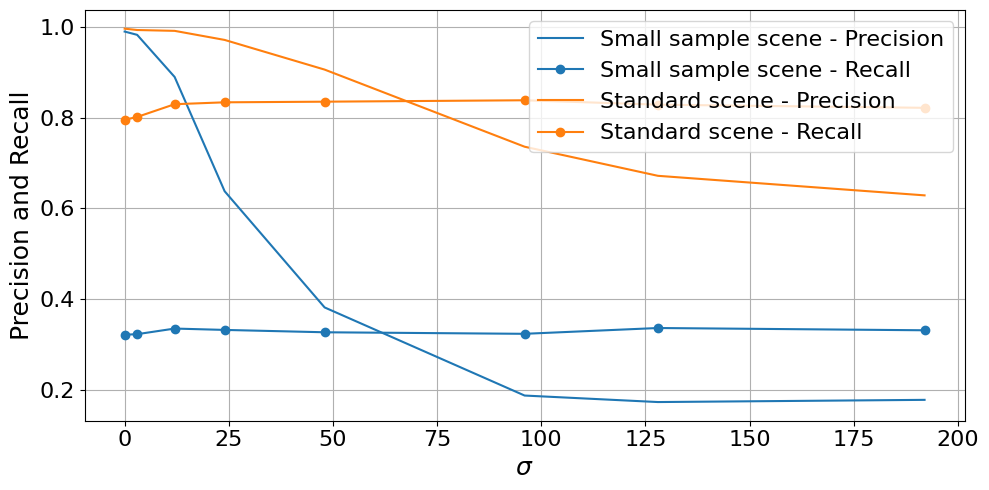

In [54]:
noise=[0,3,12,24,48,96,128,192]
plt.figure(figsize=(10,5))
precision_L, recall_L, F1_L = [], [], []
for syn in [cl00_10, cl03_10, cl12_10, cl24_10, cl48_10, cl96_10, cl128_10, cl192_10]:
    all_positives_T, TP_T, FP_T, FN_T = 0, 0, 0, 0
    for pth in syn:
        ran=np.load(pth, allow_pickle=True)
        ac_class, count = np.unique(ran.item().get('point based'), return_counts=True)
        TP_count = np.sum(count[ac_class > 0]) if 1 in ac_class else 0
        FN_count = count[ac_class == 0][0] if 0 in ac_class else 0
        FP_count = ran.item().get('mask_count')-np.sum(count[ac_class>0])

        TP_T += TP_count
        FN_T += FN_count
        FP_T += FP_count
        all_positives_T += ran.item().get('mask_count')

    precision=TP_T / (TP_T + FP_T) if (TP_T + FP_T) > 0 else 0
    recall=TP_T / (TP_T + FN_T) if (TP_T + FN_T) > 0 else 0
    precision_L.append(precision)
    recall_L.append(recall)
plt.plot(noise, precision_L,'-',c='#1f77b4', label=r'Small sample scene - Precision')
plt.plot(noise, recall_L,'o-',c='#1f77b4', label=r'Small sample scene - Recall')

precision_L, recall_L, F1_L = [], [], []
for syn in [cl00_02, cl03_02, cl12_02, cl24_02, cl48_02, cl96_02, cl128_02, cl192_02]:
    all_positives_T, TP_T, FP_T, FN_T = 0, 0, 0, 0
    for pth in syn:
        ran=np.load(pth, allow_pickle=True)
        ac_class, count = np.unique(ran.item().get('point based'), return_counts=True)
        TP_count = np.sum(count[ac_class > 0]) if 1 in ac_class else 0
        FN_count = count[ac_class == 0][0] if 0 in ac_class else 0
        FP_count = ran.item().get('mask_count')-np.sum(count[ac_class>0])

        TP_T += TP_count
        FN_T += FN_count
        FP_T += FP_count
        all_positives_T += ran.item().get('mask_count')

    precision=TP_T / (TP_T + FP_T) if (TP_T + FP_T) > 0 else 0
    recall=TP_T / (TP_T + FN_T) if (TP_T + FN_T) > 0 else 0
    precision_L.append(precision)
    recall_L.append(recall)
    F1_L.append( 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0)
plt.plot(noise, precision_L,'-',c='#ff7f0e', label=r'Standard scene - Precision')
plt.plot(noise, recall_L,'o-',c='#ff7f0e', label=r'Standard scene - Recall')
#plt.plot(noise, F1_L,'--', c='#2ca02c',label='F1 (Radius: 2-1500)')
plt.legend(loc='upper right', fontsize=16)
plt.grid()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16) 
plt.xlabel(r'$\sigma$', fontsize=18)
plt.ylabel(r'Precision and Recall', fontsize=18)
#plt.title('C: varying noise level', fontsize=18)
#plt.gcf().text(0.04, 0.5, 'Precision and Recall', fontsize=18, rotation=90, va='center')
plt.tight_layout()
plt.savefig('figure/noise_pr.png')

C:\Users\Vito\AppData\Local\Temp\ipykernel_20280\3534894074.py:36: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if c < len(ac_class):


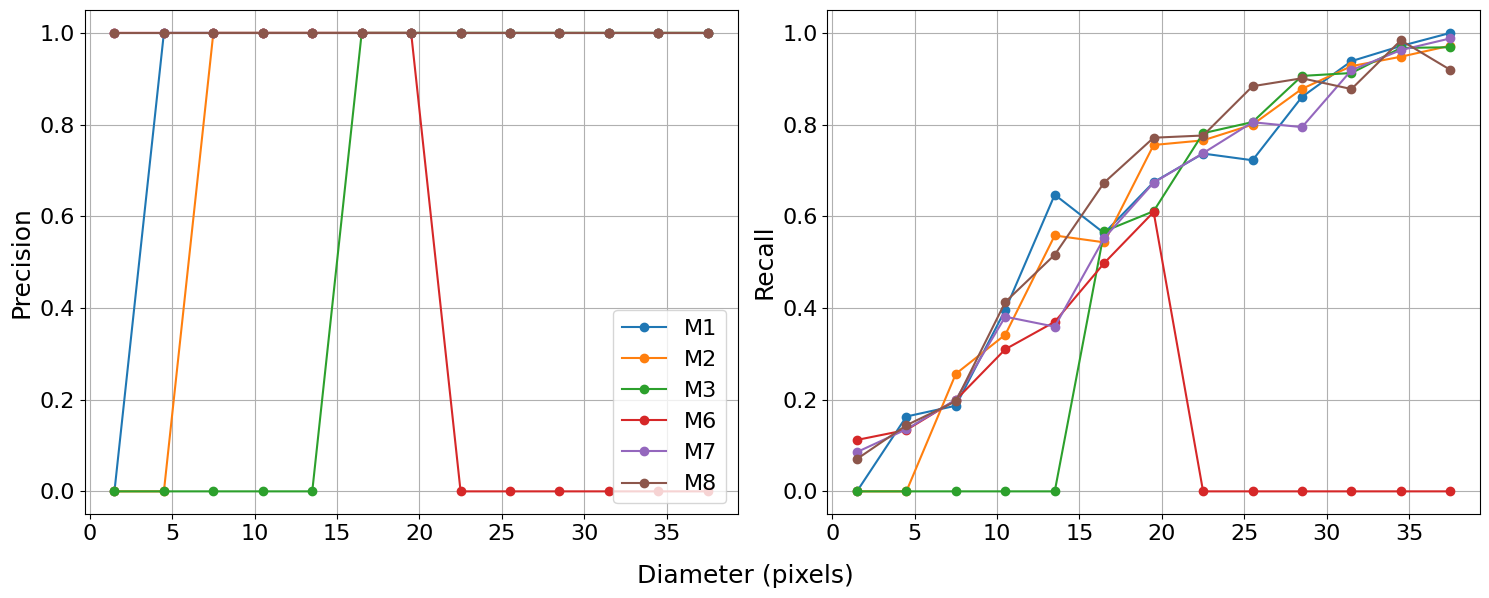

In [ ]:
syn = rs02_3000  # Change this to focus on a different rs dataset

# Define diameter bins
bin_edges = np.arange(0, 40, 3)  # Bins from 0 to 20 in steps of 2
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

Min_radi=['M1','M2','M3','M6','M7','M8']
fig, ax =plt.subplots(1,1,figsize=(10, 4))
precision_L, recall_L = [], []
for l,syn in enumerate([rs02_3000, rs04_3000, rs08, rs01_10, rs01_100, rs01_1000]):
    precision_binned = []
    recall_binned = []

    for i in range(len(bin_edges) - 1):
        TP_T, FP_T, FN_T = 0, 0, 0  
    
        for pth in syn:
            ran = np.load(pth, allow_pickle=True)
            area = np.array(ran.item().get('area'))
            area = (np.sqrt(area / np.pi) / 0.2) * 2  
            ac = np.array(ran.item().get('point based'))

            mask = (area >= bin_edges[i]) & (area < bin_edges[i + 1])
            ac_bin = ac[mask]
            area_bin = area[mask]

            if len(area_bin) == 0:
                continue 

            ac_class, count = np.unique(ac_bin, return_counts=True)

            TP_count = np.sum(count[ac_class > 0]) if 1 in ac_class else 0
            FN_count = count[ac_class == 0][0] if 0 in ac_class else 0
            multi = 0
            for c in np.where(ac_class > 1):
                if c < len(ac_class):
                    multi += (count[c] * ac_class[c]).item()
            FP_count = multi - np.sum(count[ac_class > 1])

            TP_T += TP_count
            FN_T += FN_count
            FP_T += FP_count

        precision = TP_T / (TP_T + FP_T) if (TP_T + FP_T) > 0 else 0
        recall = TP_T / (TP_T + FN_T) if (TP_T + FN_T) > 0 else 0

        precision_binned.append(precision)
        recall_binned.append(recall)

    # Plot the binned precision and recall
    #ax[0].plot(bin_centers, precision_binned, 'o-', label=f'{Min_radi[l]}')#'$r_{min}$'+f' = {Min_radi[l]}'
    ax[0].plot(bin_centers, recall_binned, 'o-', label=f'{Min_radi[l]}')
ax[0].legend(loc='lower right', fontsize=16)
#ax[0].grid()
ax[0].grid()
#ax[0].set_title('A: Precision', fontsize=20)
#ax[0].set_title('B: Recall', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.xlabel('Diameter (pixels)', fontsize=16)
ax[0].set_ylabel('Metrics', fontsize=18)
plt.figtext(0.5, 0.01, 'Diameter (pixels)', ha='center', fontsize=18)
plt.tight_layout()
plt.savefig('figure\detection_limit.png')
plt.show()

C:\Users\Vito\AppData\Local\Temp\ipykernel_20280\146273341.py:38: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if c < len(ac_class):


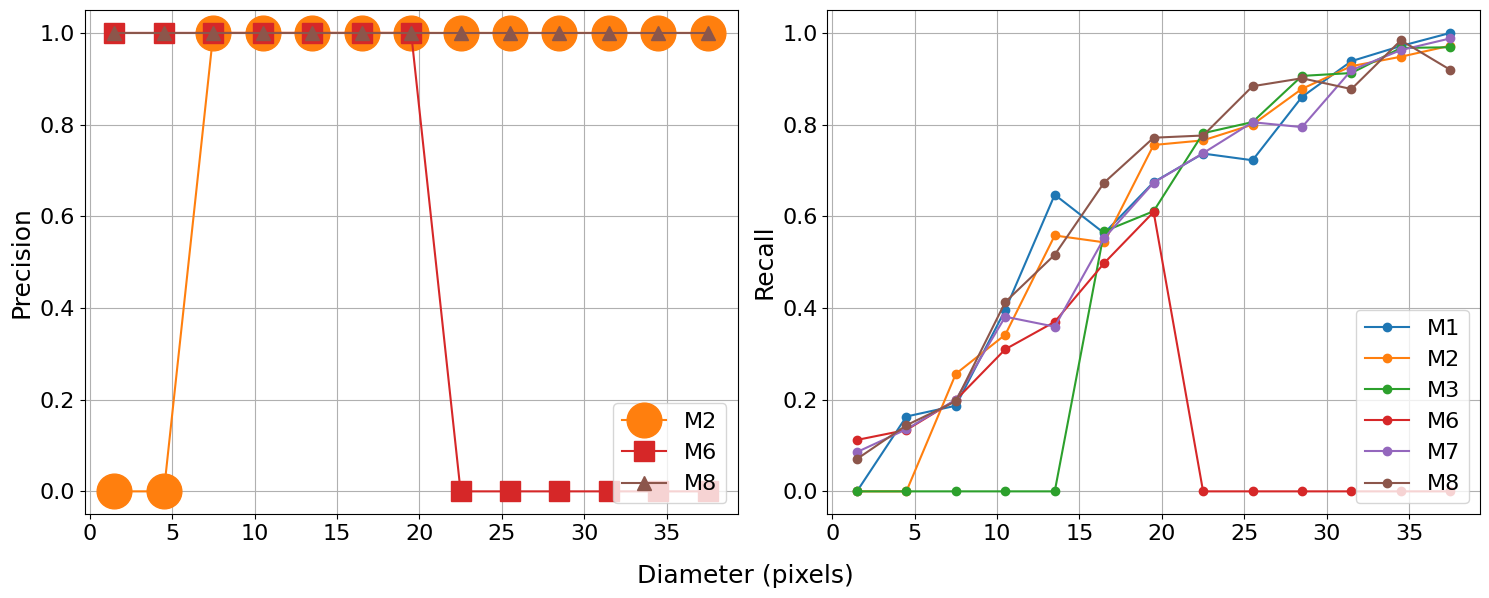

In [69]:
syn = rs02_3000  # Change this to focus on a different rs dataset

# Define diameter bins
bin_edges = np.arange(0, 40, 3)  # Bins from 0 to 20 in steps of 2
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

Min_radi=['M1','M2','M3','M6','M7','M8']
sym=['-','o-','-','s-','-','^-']
ms=[0,25,0,15,0,10]
fig, ax =plt.subplots(1,2,figsize=(15, 6))
precision_L, recall_L = [], []
for l,syn in enumerate([rs02_3000, rs04_3000, rs08, rs01_10, rs01_100, rs01_1000]):
    precision_binned = []
    recall_binned = []

    for i in range(len(bin_edges) - 1):
        TP_T, FP_T, FN_T = 0, 0, 0  
    
        for pth in syn:
            ran = np.load(pth, allow_pickle=True)
            area = np.array(ran.item().get('area'))
            area = (np.sqrt(area / np.pi) / 0.2) * 2  
            ac = np.array(ran.item().get('point based'))

            mask = (area >= bin_edges[i]) & (area < bin_edges[i + 1])
            ac_bin = ac[mask]
            area_bin = area[mask]

            if len(area_bin) == 0:
                continue 

            ac_class, count = np.unique(ac_bin, return_counts=True)

            TP_count = np.sum(count[ac_class > 0]) if 1 in ac_class else 0
            FN_count = count[ac_class == 0][0] if 0 in ac_class else 0
            multi = 0
            for c in np.where(ac_class > 1):
                if c < len(ac_class):
                    multi += (count[c] * ac_class[c]).item()
            FP_count = multi - np.sum(count[ac_class > 1])

            TP_T += TP_count
            FN_T += FN_count
            FP_T += FP_count

        precision = TP_T / (TP_T + FP_T) if (TP_T + FP_T) > 0 else 0
        recall = TP_T / (TP_T + FN_T) if (TP_T + FN_T) > 0 else 0

        precision_binned.append(precision)
        recall_binned.append(recall)

    # Plot the binned precision and recall
    if l%2 == 1:
        ax[0].plot(bin_centers, precision_binned,sym[l], label=f'{Min_radi[l]}', markersize=ms[l])#'$r_{min}$'+f' = {Min_radi[l]}'
    else:
        ax[0].plot([],[])
    ax[1].plot(bin_centers, recall_binned, 'o-', label=f'{Min_radi[l]}')
ax[1].legend(loc='lower right', fontsize=16)
ax[0].legend(loc='lower right', fontsize=16)
ax[0].grid()
ax[1].grid()
#ax[0].set_title('A: Precision', fontsize=20)
#ax[0].set_title('B: Recall', fontsize=20)
ax[0].tick_params(axis='both', labelsize=16)
ax[1].tick_params(axis='both', labelsize=16)
#plt.xlabel('Diameter (pixels)', fontsize=16)
ax[0].set_ylabel('Precision', fontsize=18)
ax[1].set_ylabel('Recall', fontsize=18)
plt.figtext(0.5, 0.01, 'Diameter (pixels)', ha='center', fontsize=18)
plt.tight_layout(rect=[0,0.05,1,0.99])
plt.savefig('figure\detection_limit.png')
plt.show()

C:\Users\Vito\AppData\Local\Temp\ipykernel_20280\1959849682.py:38: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if c < len(ac_class):
C:\Users\Vito\AppData\Local\Temp\ipykernel_20280\1959849682.py:88: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if c < len(ac_class):


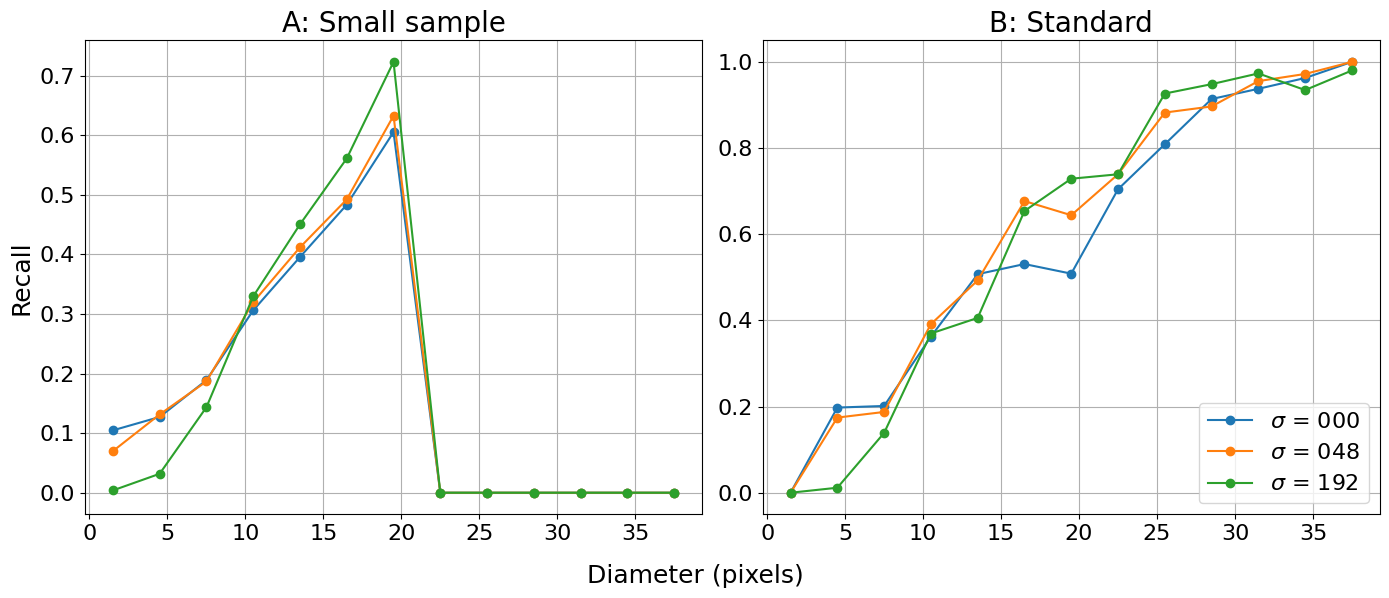

In [55]:
bin_edges = np.arange(0, 40, 3)  # Bins from 0 to 20 in steps of 2
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

#Min_radi=['000','003','012','024','048','096','128','192']
fig, ax =plt.subplots(1,2,figsize=(14, 6))
#precision_L, recall_L = [], []
#noise=[0,3,12,24,48,96,128,192]
#for l,syn in enumerate([cl00_10, cl03_10, cl12_10, cl24_10, cl48_10, cl96_10, cl128_10, cl192_10]):
Min_radi=['000','048','192']
precision_L, recall_L = [], []
noise=[0,48,192]
for l,syn in enumerate([cl00_10, cl48_10, cl192_10]):
    precision_binned = []
    recall_binned = []

    for i in range(len(bin_edges) - 1):
        TP_T, FP_T, FN_T = 0, 0, 0  
    
        for pth in syn:
            ran = np.load(pth, allow_pickle=True)
            area = np.array(ran.item().get('area'))
            area = (np.sqrt(area / np.pi) / 0.2) * 2  
            ac = np.array(ran.item().get('point based'))

            mask = (area >= bin_edges[i]) & (area < bin_edges[i + 1])
            ac_bin = ac[mask]
            area_bin = area[mask]

            if len(area_bin) == 0:
                continue 

            ac_class, count = np.unique(ac_bin, return_counts=True)

            TP_count = np.sum(count[ac_class > 0]) if 1 in ac_class else 0
            FN_count = count[ac_class == 0][0] if 0 in ac_class else 0
            multi = 0
            for c in np.where(ac_class > 1):
                if c < len(ac_class):
                    multi += (count[c] * ac_class[c]).item()
            FP_count = multi - np.sum(count[ac_class > 1])

            TP_T += TP_count
            FN_T += FN_count
            FP_T += FP_count

        precision = TP_T / (TP_T + FP_T) if (TP_T + FP_T) > 0 else 0
        recall = TP_T / (TP_T + FN_T) if (TP_T + FN_T) > 0 else 0

        precision_binned.append(precision)
        recall_binned.append(recall)

    # Plot the binned precision and recall
    ax[0].plot(bin_centers, recall_binned, 'o-', label=r'$\sigma$ = '+f'{Min_radi[l]}')
ax[0].tick_params(labelsize=16) 
#Min_radi=['000','003','012','024','048','096','128','192']
#precision_L, recall_L = [], []
#noise=[0,3,12,24,48,96,128,192]
#for l,syn in enumerate([cl00_02, cl03_02, cl12_02, cl24_02, cl48_02, cl96_02, cl128_02, cl192_02]):
Min_radi=['000','048','192']
precision_L, recall_L = [], []
noise=[0,48,192]
for l,syn in enumerate([cl00_02, cl48_02, cl192_02]):
    precision_binned = []
    recall_binned = []

    for i in range(len(bin_edges) - 1):
        TP_T, FP_T, FN_T = 0, 0, 0  
    
        for pth in syn:
            ran = np.load(pth, allow_pickle=True)
            area = np.array(ran.item().get('area'))
            area = (np.sqrt(area / np.pi) / 0.2) * 2  
            ac = np.array(ran.item().get('point based'))

            mask = (area >= bin_edges[i]) & (area < bin_edges[i + 1])
            ac_bin = ac[mask]
            area_bin = area[mask]

            if len(area_bin) == 0:
                continue 

            ac_class, count = np.unique(ac_bin, return_counts=True)

            TP_count = np.sum(count[ac_class > 0]) if 1 in ac_class else 0
            FN_count = count[ac_class == 0][0] if 0 in ac_class else 0
            multi = 0
            for c in np.where(ac_class > 1):
                if c < len(ac_class):
                    multi += (count[c] * ac_class[c]).item()
            FP_count = multi - np.sum(count[ac_class > 1])

            TP_T += TP_count
            FN_T += FN_count
            FP_T += FP_count

        precision = TP_T / (TP_T + FP_T) if (TP_T + FP_T) > 0 else 0
        recall = TP_T / (TP_T + FN_T) if (TP_T + FN_T) > 0 else 0

        precision_binned.append(precision)
        recall_binned.append(recall)

    # Plot the binned precision and recall
    #ax[0].plot(bin_centers, precision_binned, 'o-', label=f'{Min_radi[l]}')#'$r_{min}$'+f' = {Min_radi[l]}'
    ax[1].plot(bin_centers, recall_binned, 'o-', label=r'$\sigma$ = '+f'{Min_radi[l]}')
#ax[0].legend(loc='lower right', fontsize=12)
ax[1].legend(loc='lower right', fontsize=16)
ax[0].grid()
ax[1].grid()
ax[0].set_title('A: Small sample', fontsize=20)
ax[1].set_title('B: Standard', fontsize=20)
#plt.xticks(fontsize=16)
#plt.yticks(fontsize=16)
ax[1].tick_params(labelsize=16) 
#plt.xlabel('Diameter (pixels)', fontsize=16)
ax[0].set_ylabel('Recall', fontsize=18)
plt.figtext(0.5, 0.01, 'Diameter (pixels)', ha='center', fontsize=18)
plt.tight_layout(rect=[0,0.05,1,0.99])
plt.savefig('figure\sigma_recall_noise.png')
plt.show()

C:\Users\Vito\AppData\Local\Temp\ipykernel_3800\3968080466.py:36: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if c < len(ac_class):


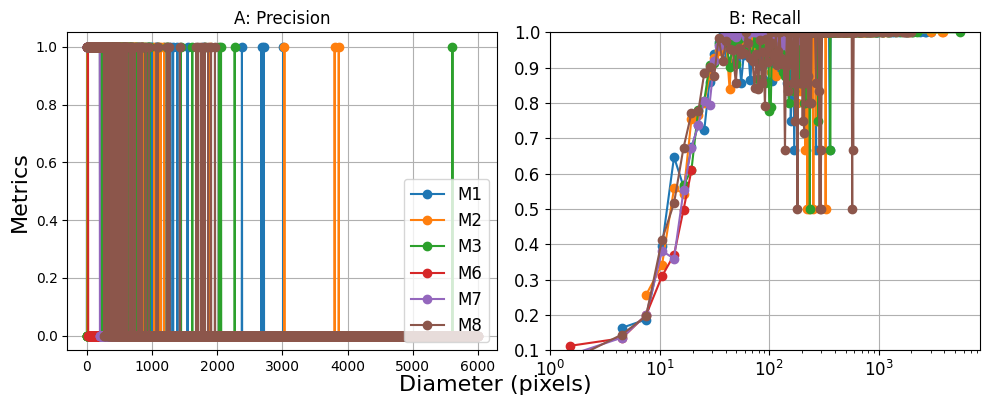

In [318]:
syn = rs02_3000  # Change this to focus on a different rs dataset

# Define diameter bins
bin_edges = np.arange(0, 6000, 3)  # Bins from 0 to 20 in steps of 2
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

Min_radi=['M1','M2','M3','M6','M7','M8']
fig, ax =plt.subplots(1,2,figsize=(10, 4))
precision_L, recall_L = [], []
for l,syn in enumerate([rs02_3000, rs04_3000, rs08, rs01_10, rs01_100, rs01_1000]):
    precision_binned = []
    recall_binned = []

    for i in range(len(bin_edges) - 1):
        TP_T, FP_T, FN_T = 0, 0, 0  
    
        for pth in syn:
            ran = np.load(pth, allow_pickle=True)
            area = np.array(ran.item().get('area'))
            area = (np.sqrt(area / np.pi) / 0.2) * 2  
            ac = np.array(ran.item().get('point based'))

            mask = (area >= bin_edges[i]) & (area < bin_edges[i + 1])
            ac_bin = ac[mask]
            area_bin = area[mask]

            if len(area_bin) == 0:
                continue 

            ac_class, count = np.unique(ac_bin, return_counts=True)

            TP_count = np.sum(count[ac_class > 0]) if 1 in ac_class else 0
            FN_count = count[ac_class == 0][0] if 0 in ac_class else 0
            multi = 0
            for c in np.where(ac_class > 1):
                if c < len(ac_class):
                    multi += (count[c] * ac_class[c]).item()
            FP_count = multi - np.sum(count[ac_class > 1])

            TP_T += TP_count
            FN_T += FN_count
            FP_T += FP_count

        precision = TP_T / (TP_T + FP_T) if (TP_T + FP_T) > 0 else 0
        recall = TP_T / (TP_T + FN_T) if (TP_T + FN_T) > 0 else 0

        precision_binned.append(precision)
        recall_binned.append(recall)

    # Plot the binned precision and recall
    recall_binned=np.array(recall_binned)
    ax[0].plot(bin_centers, precision_binned, 'o-', label=f'{Min_radi[l]}')#'$r_{min}$'+f' = {Min_radi[l]}'
    ax[1].plot(bin_centers[recall_binned>0], recall_binned[recall_binned>0], 'o-', label=f'{Min_radi[l]}')
ax[0].legend(loc='lower right', fontsize=12)
ax[0].grid()
ax[1].grid()
ax[0].set_title('A: Precision')
ax[1].set_title('B: Recall')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0.1,1)
plt.xscale('log')
#plt.xlabel('Diameter (pixels)', fontsize=16)
ax[0].set_ylabel('Metrics', fontsize=16)
plt.figtext(0.5, 0.01, 'Diameter (pixels)', ha='center', fontsize=16)
plt.tight_layout()
#plt.savefig('figure\detection_limit.png')
plt.show()

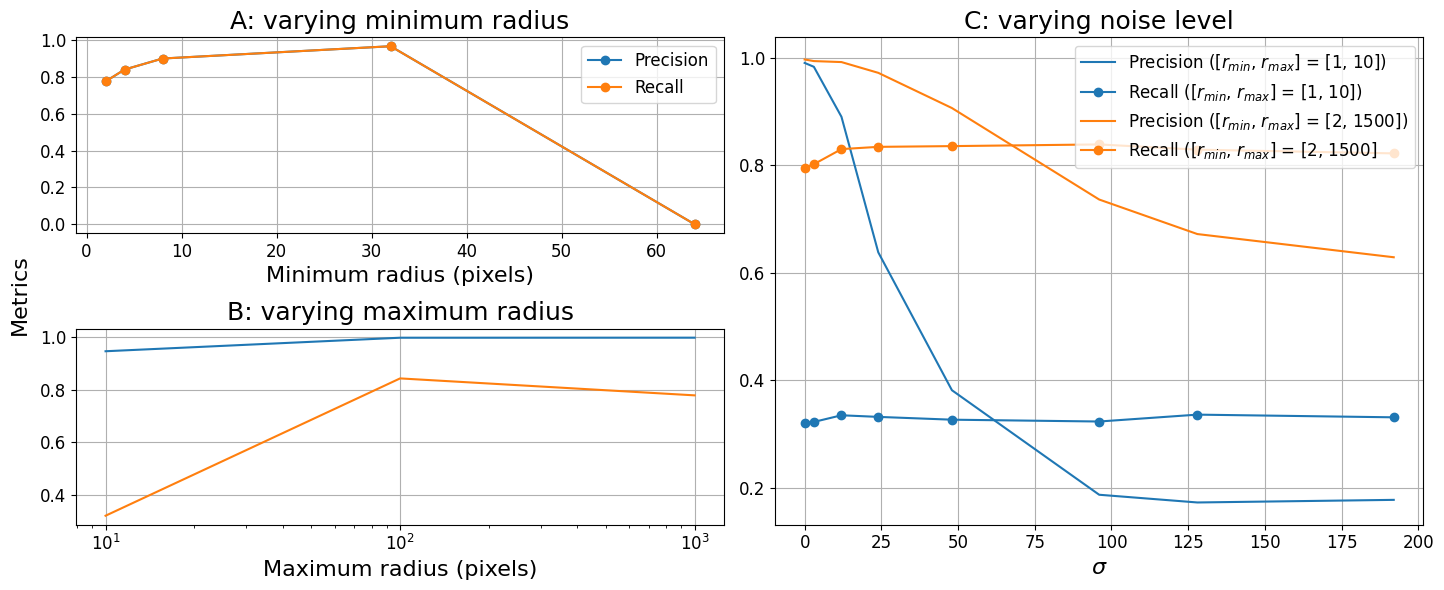

In [ ]:
Min_radi=[2,4,8,32,64]
plt.figure(figsize=(15, 6))
plt.subplot(2, 2, 1)
precision_L, recall_L = [], []
for syn in [rs02_3000, rs04_3000, rs08, rs32, rs64]:
    all_positives_T, TP_T, FP_T, FN_T = 0, 0, 0, 0
    for pth in syn:
        ran=np.load(pth, allow_pickle=True)

        area = np.array(ran.item().get('area'))
        area=(np.sqrt(area/np.pi)/0.2)*2
        ac = np.array(ran.item().get('point based'))

        ac=ac[area<100]
        area=area[area<100]

        ac_class, count = np.unique(ac, return_counts=True)
        
        TP_count = np.sum(count[ac_class > 0]) if 1 in ac_class else 0
        FN_count = count[ac_class == 0][0] if 0 in ac_class else 0
        FP_count = len(area)-np.sum(count[ac_class>0])

        TP_T += TP_count
        FN_T += FN_count
        FP_T += FP_count
        all_positives_T += len(area)

    precision=TP_T / (TP_T + FP_T) if (TP_T + FP_T) > 0 else 0
    recall=TP_T / (TP_T + FN_T) if (TP_T + FN_T) > 0 else 0
    precision_L.append(precision)
    recall_L.append(recall)
plt.plot(Min_radi, precision_L,'o-', label='Precision')
plt.plot(Min_radi, recall_L,'o-', label='Recall')
plt.legend(loc='upper right', fontsize=12)
plt.grid()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12) 
#plt.ylabel('Metrics', fontsize=16)
plt.xlabel('Minimum radius (pixels)', fontsize=16)
plt.title('A: varying minimum radius', fontsize=18)

plt.subplot(2, 2, 3)
Max_radi=[10,100,1000]
precision_L, recall_L = [], []
for syn in [rs01_10, rs01_100, rs01_1000]:
    all_positives_T, TP_T, FP_T, FN_T = 0, 0, 0, 0
    for pth in syn:
        ran=np.load(pth, allow_pickle=True)
        ac_class, count = np.unique(ran.item().get('point based'), return_counts=True)
        TP_count = np.sum(count[ac_class > 0]) if 1 in ac_class else 0
        FN_count = count[ac_class == 0][0] if 0 in ac_class else 0
        FP_count = ran.item().get('mask_count')-np.sum(count[ac_class>0])

        TP_T += TP_count
        FN_T += FN_count
        FP_T += FP_count
        all_positives_T += ran.item().get('mask_count')

    precision=TP_T / (TP_T + FP_T) if (TP_T + FP_T) > 0 else 0
    recall=TP_T / (TP_T + FN_T) if (TP_T + FN_T) > 0 else 0
    precision_L.append(precision)
    recall_L.append(recall)
plt.plot(Max_radi, precision_L,c='#1f77b4', label='Precision')
plt.plot(Max_radi, recall_L,c='#ff7f0e', label='Recall')
plt.xscale('log')
plt.grid()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12) 
plt.xlabel('Maximum radius (pixels)', fontsize=16)
plt.title('B: varying maximum radius', fontsize=18)


plt.subplot(1, 2, 2)
noise=[0,3,12,24,48,96,128,192]
precision_L, recall_L, F1_L = [], [], []
for syn in [cl00_10, cl03_10, cl12_10, cl24_10, cl48_10, cl96_10, cl128_10, cl192_10]:
    all_positives_T, TP_T, FP_T, FN_T = 0, 0, 0, 0
    for pth in syn:
        ran=np.load(pth, allow_pickle=True)
        ac_class, count = np.unique(ran.item().get('point based'), return_counts=True)
        TP_count = np.sum(count[ac_class > 0]) if 1 in ac_class else 0
        FN_count = count[ac_class == 0][0] if 0 in ac_class else 0
        FP_count = ran.item().get('mask_count')-np.sum(count[ac_class>0])

        TP_T += TP_count
        FN_T += FN_count
        FP_T += FP_count
        all_positives_T += ran.item().get('mask_count')

    precision=TP_T / (TP_T + FP_T) if (TP_T + FP_T) > 0 else 0
    recall=TP_T / (TP_T + FN_T) if (TP_T + FN_T) > 0 else 0
    precision_L.append(precision)
    recall_L.append(recall)
plt.plot(noise, precision_L,'-',c='#1f77b4', label=r'Precision ([$r_{min}$, $r_{max}$] = [1, 10])')
plt.plot(noise, recall_L,'o-',c='#1f77b4', label=r'Recall ([$r_{min}$, $r_{max}$] = [1, 10])')

precision_L, recall_L, F1_L = [], [], []
for syn in [cl00_02, cl03_02, cl12_02, cl24_02, cl48_02, cl96_02, cl128_02, cl192_02]:
    all_positives_T, TP_T, FP_T, FN_T = 0, 0, 0, 0
    for pth in syn:
        ran=np.load(pth, allow_pickle=True)
        ac_class, count = np.unique(ran.item().get('point based'), return_counts=True)
        TP_count = np.sum(count[ac_class > 0]) if 1 in ac_class else 0
        FN_count = count[ac_class == 0][0] if 0 in ac_class else 0
        FP_count = ran.item().get('mask_count')-np.sum(count[ac_class>0])

        TP_T += TP_count
        FN_T += FN_count
        FP_T += FP_count
        all_positives_T += ran.item().get('mask_count')

    precision=TP_T / (TP_T + FP_T) if (TP_T + FP_T) > 0 else 0
    recall=TP_T / (TP_T + FN_T) if (TP_T + FN_T) > 0 else 0
    precision_L.append(precision)
    recall_L.append(recall)
    F1_L.append( 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0)
plt.plot(noise, precision_L,'-',c='#ff7f0e', label=r'Precision ([$r_{min}$, $r_{max}$] = [2, 1500])')
plt.plot(noise, recall_L,'o-',c='#ff7f0e', label=r'Recall ([$r_{min}$, $r_{max}$] = [2, 1500]')
#plt.plot(noise, F1_L,'--', c='#2ca02c',label='F1 (Radius: 2-1500)')
plt.legend(loc='upper right', fontsize=12)
plt.grid()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12) 
plt.xlabel(r'$\sigma$', fontsize=16)
plt.title('C: varying noise level', fontsize=18)
plt.gcf().text(0.04, 0.5, 'Metrics', fontsize=16, rotation=90, va='center')
plt.tight_layout(rect=[0.05, 0, 1, 1])
#plt.savefig('figure/ac_pr_synth.png')


C:\Users\Vito\AppData\Local\Temp\ipykernel_21020\1571102796.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar
C:\Users\Vito\AppData\Local\Temp\ipykernel_21020\1571102796.py:81: RuntimeWarning: divide by zero encountered in log10
  ax2 = ax.secondary_xaxis('top', functions=(lambda x: (np.sqrt(10**x / np.pi))/(0.2), lambda x: np.log10((x*0.2)**2) * np.pi))


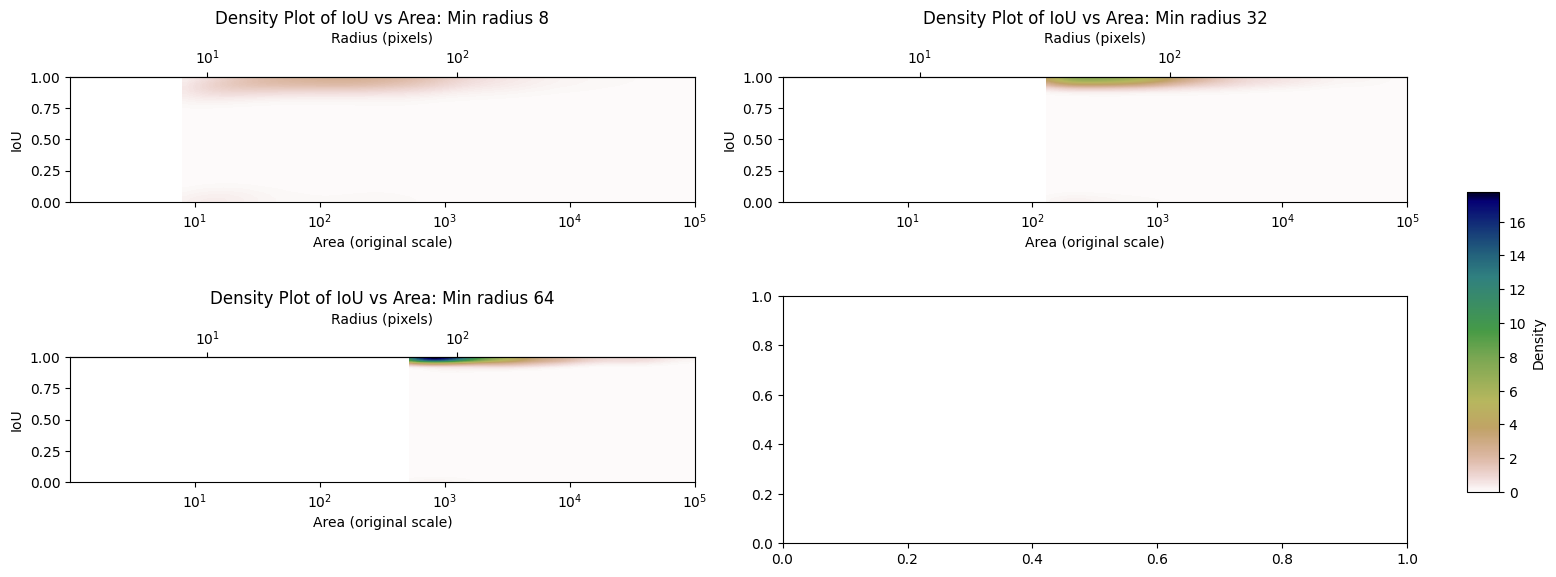

In [18]:
from scipy import stats

DSL = [rs08, rs32, rs64]
titles = ['Min radius 8', 'Min radius 32', 'Min radius 64']

# Initialize the grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 6))
cmap = plt.cm.gist_earth_r  # Define the colormap

# Initialize variables for global Z range
global_min, global_max = float('inf'), float('-inf')

# First pass: Compute the global min and max of Z
for i in range(len(DSL)):
    All_iou = []
    All_area = []
    for pth in DSL[i]:
        ran = np.load(pth, allow_pickle=True)
        All_area.append(ran.item().get('area'))
        All_iou.append(ran.item().get('iou'))

    All_area = np.hstack(All_area)
    All_area = np.log10(All_area)
    All_iou = np.abs(np.hstack(All_iou))

    xmin, xmax = All_area.min(), All_area.max()
    ymin, ymax = All_iou.min(), All_iou.max()

    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([All_area, All_iou])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)

    global_min = min(global_min, Z.min())
    global_max = max(global_max, Z.max())

# Second pass: Plot all subplots with the universal colorbar
for i in range(len(DSL)):
    All_iou = []
    All_area = []
    for pth in DSL[i]:
        ran = np.load(pth, allow_pickle=True)
        All_area.append(ran.item().get('area'))
        All_iou.append(ran.item().get('iou'))

    All_area = np.hstack(All_area)
    All_area = np.log10(All_area)
    All_iou = np.abs(np.hstack(All_iou))

    xmin, xmax = All_area.min(), All_area.max()
    ymin, ymax = All_iou.min(), All_iou.max()

    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([All_area, All_iou])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)

    # Plot the density image on the corresponding subplot
    ax = axs[i // 2, i % 2]
    im = ax.imshow(
        np.rot90(Z),
        cmap=cmap,
        extent=[xmin, xmax, ymin, ymax],
        vmin=global_min,  # Use global min
        vmax=global_max   # Use global max
    )

    # Customize the axes
    log_ticks = [1, 2, 3, 4, 5]
    log_labels = [f"$10^{{{tick}}}$" for tick in log_ticks]
    ax.set_xticks(log_ticks)
    ax.set_xticklabels(log_labels)
    ax.set_xlim([0, 5])
    ax.set_ylim([0, 1])
    ax.set_xlabel('Area (original scale)')
    ax.set_ylabel('IoU')
    ax.set_title(f'Density Plot of IoU vs Area: {titles[i]}')
    #ax = plt.gca()
    ax2 = ax.secondary_xaxis('top', functions=(lambda x: (np.sqrt(10**x / np.pi))/(0.2), lambda x: np.log10((x*0.2)**2) * np.pi))
    ax2.set_xlabel('Radius (pixels)')
    log_ticks = [10,100,1000]
    log_labels = [f"$10^{{{tick+1}}}$" for tick in range(3)]
    ax2.set_xticks(log_ticks)
    ax2.set_xticklabels(log_labels)
    

# Add a single vertical colorbar on the right
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.5])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, label='Density', orientation='vertical')

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar
plt.show()



In [27]:
def ks_DS(DS_pths):
    sizes=[]
    sizes_re=[]
    for pth in DS_pths:
        ran=np.load(pth, allow_pickle=True)
        sizes += list(ran.item().get('area'))
        sizes_re += list(ran.item().get('segment area'))
    
    sizes = np.sort(sizes)/(0.2*0.2)

    sizes_re = np.sort(sizes_re)

    #minmin=min(min(sizes),min(sizes_re))
    #maxmax=max(max(sizes),max(sizes_re))

    #sizes=sizes[sizes>minmin]
    #sizes_re=sizes_re[sizes_re>minmin]

    #sizes=sizes[sizes<maxmax]
    #sizes_re=sizes_re[sizes_re<maxmax]
    ks=ks_2samp(sizes_re,sizes, method= 'exact', alternative='two-sided')
    return ks
def cdf(DS_pths, title_label, result=True):
    sizes=[]
    sizes_re=[]
    for pth in DS_pths:
        ran=np.load(pth, allow_pickle=True)
        sizes += list(ran.item().get('area'))
        
        if result:
            sizes_re += list(ran.item().get('segment area'))
    
    sizes = np.sort(sizes)/(0.2*0.2)
    cdf = np.arange(1, len(sizes) + 1) / len(sizes)
    plt.plot(sizes, cdf, linestyle="-", label='Label')
    plt.title(title_label, fontsize=20)
    if result:
        sizes_re = np.sort(sizes_re)
        cdf_re = np.arange(1, len(sizes_re) + 1) / len(sizes_re)
        plt.plot(sizes_re, cdf_re, linestyle="--", label='tile SAM')
        ks_test=ks_DS(DS_pths)
        plt.title(title_label+'\n'+fr'K-S $D$: {np.round(ks_test[0],2):.2}, $p$: {np.round(ks_test[1],2):.2}'+'\n'+fr'$n_l$: {len(sizes)}, $n_s$: {len(sizes_re)}', fontsize=20)

    
    plt.xscale("log")
    plt.xlabel("Area (pixels)", fontsize=18)
    plt.ylabel("Cumulative Probability", fontsize=18) 
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)       
    plt.grid(True)

In [ ]:
sizes=[]
sizes_re=[]
for pth in rs32:
    ran=np.load(pth, allow_pickle=True)
    sizes += list(ran.item().get('area'))
    sizes_re += list(ran.item().get('segment area'))

sizes = np.sort(sizes)/(0.2*0.2).astype

sizes_re = np.sort(sizes_re)
ks=ks_2samp(sizes, sizes_re)

In [100]:
min(sizes)

3208.9999999999995

In [57]:
ks_DS(rs32)

KstestResult(statistic=0.03473438591846723, pvalue=0.4823253702045369, statistic_location=3852.0, statistic_sign=-1)

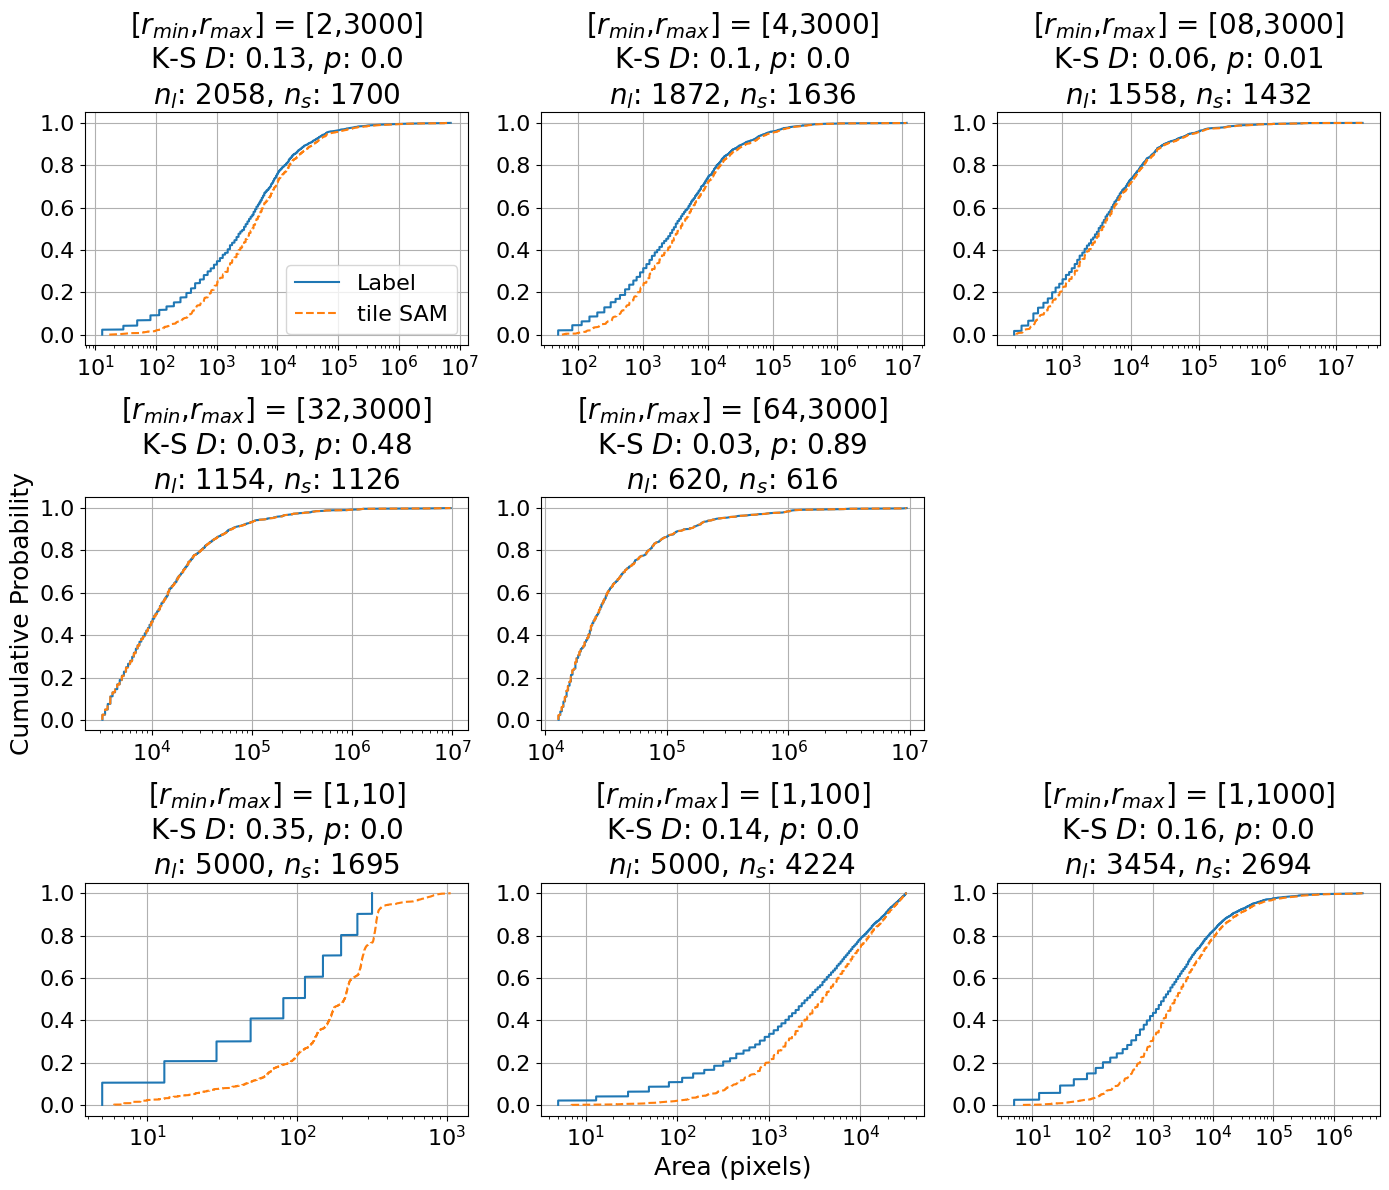

In [28]:

plt.figure(figsize=(14,12))
plt.subplot(3,3,1)
cdf(rs02_3000, r"[$r_{min}$,$r_{max}$] = [2,3000]")
plt.xlabel('')
plt.ylabel('')
plt.legend(fontsize=16)
plt.subplot(3,3,2)
cdf(rs04_3000, r"[$r_{min}$,$r_{max}$] = [4,3000]")
plt.xlabel('')
plt.ylabel('')
plt.subplot(3,3,3)
cdf(rs08, r"[$r_{min}$,$r_{max}$] = [08,3000]")
plt.xlabel('')
plt.ylabel('')
plt.subplot(3,3,4)
cdf(rs32, r"[$r_{min}$,$r_{max}$] = [32,3000]")
plt.xlabel('')
plt.subplot(3,3,5)
cdf(rs64, r"[$r_{min}$,$r_{max}$] = [64,3000]")
plt.xlabel('')
plt.ylabel('')
plt.subplot(3,3,7)
cdf(rs01_10, r"[$r_{min}$,$r_{max}$] = [1,10]")
plt.xlabel('')
plt.ylabel('')
plt.subplot(3,3,8)
cdf(rs01_100, r"[$r_{min}$,$r_{max}$] = [1,100]")
#plt.xlabel('')
plt.ylabel('')
plt.subplot(3,3,9)
cdf(rs01_1000, r"[$r_{min}$,$r_{max}$] = [1,1000]")
plt.ylabel('')
plt.xlabel('')
#plt.subplot(3,3,9)
#cdf(rs08_100, "Radii: 08-100")
#plt.xlabel('')
#plt.ylabel('')
#plt.suptitle("Size distribution of synthetic scene")
plt.tight_layout()
plt.savefig('C:/Users/Vito/Documents/MasterThesis/figure/size_dist_synth_b100.png')

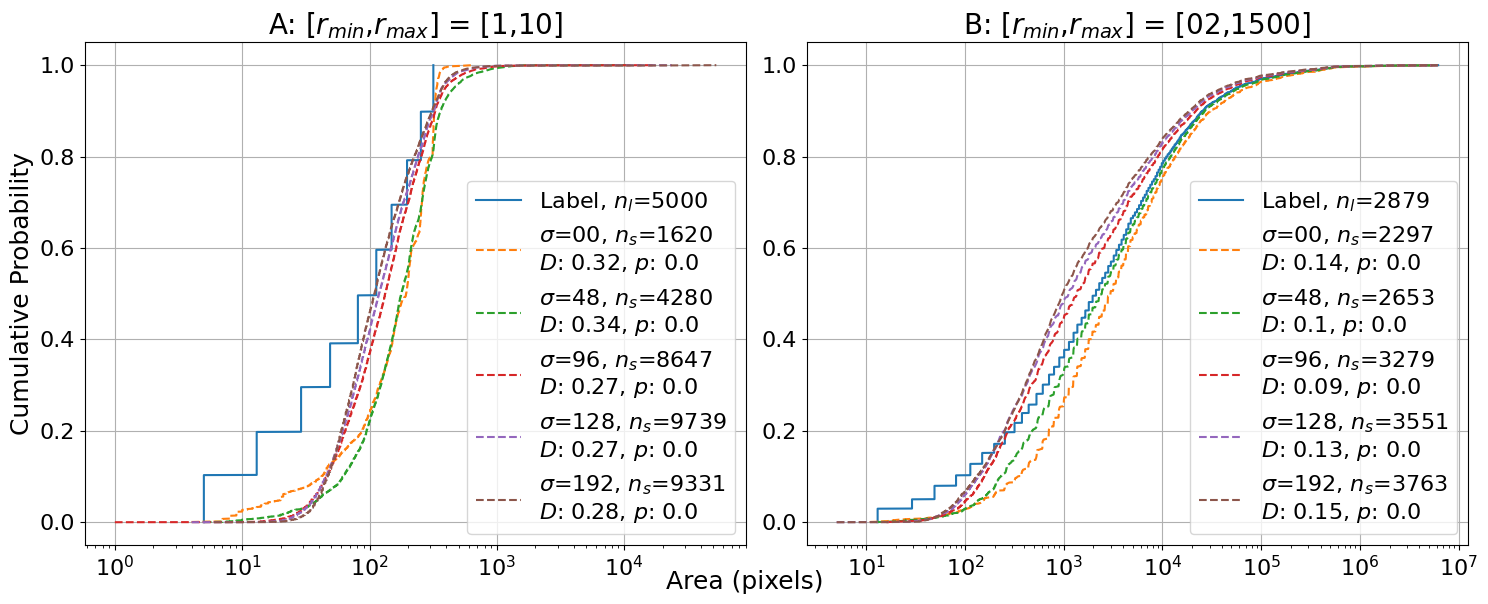

In [26]:
def cdf_cl(DS_pths, label, org=False):
    if org:
        sizes=[]
        for pth in DS_pths:
            ran=np.load(pth, allow_pickle=True)
            sizes += list(ran.item().get('area'))
            
        sizes = np.sort(sizes)/(0.2*0.2)
        cdf = np.arange(1, len(sizes) + 1) / len(sizes)
        plt.plot(sizes, cdf, label=fr'Label, $n_l$={len(sizes)}')
    
    sizes=[]
    for pth in DS_pths:
        ran=np.load(pth, allow_pickle=True)
        sizes += list(ran.item().get('segment area'))
    sizes = np.sort(sizes)
    cdf = np.arange(1, len(sizes) + 1) / len(sizes)
    ks_test=ks_DS(DS_pths)
    plt.plot(sizes, cdf, linestyle='--', label=label+fr', $n_s$={len(sizes)}'+'\n'+fr'$D$: {np.round(ks_test[0],2):.2}, $p$: {np.round(ks_test[1],2):.2}')


plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title(r"A: [$r_{min}$,$r_{max}$] = [1,10]", fontsize=20)
cdf_cl(cl00_10, r'$\sigma$=00',True)
cdf_cl(cl48_10, r'$\sigma$=48')
cdf_cl(cl96_10, r'$\sigma$=96')
cdf_cl(cl128_10, r'$\sigma$=128')
cdf_cl(cl192_10, r'$\sigma$=192')
plt.legend(fontsize=16)

    
plt.xscale("log")
#plt.xlabel("Area (pixels)", fontsize=16)
plt.ylabel("Cumulative Probability", fontsize=18) 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)       
plt.grid(True)

plt.subplot(1,2,2)
plt.title(r"B: [$r_{min}$,$r_{max}$] = [02,1500]", fontsize=20)
cdf_cl(cl00_02, r'$\sigma$=00',True)
cdf_cl(cl48_02, r'$\sigma$=48')
cdf_cl(cl96_02, r'$\sigma$=96')
cdf_cl(cl128_02, r'$\sigma$=128')
cdf_cl(cl192_02, r'$\sigma$=192')
plt.xscale("log")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)       
plt.grid(True)
#plt.xlabel("Area (pixels)", fontsize=16)
plt.figtext(0.5, 0.01, 'Area (pixels)', ha='center', fontsize=18)
plt.tight_layout()
plt.savefig('C:/Users/Vito/Documents/MasterThesis/figure/cl_size_dist_synth_b100.png')

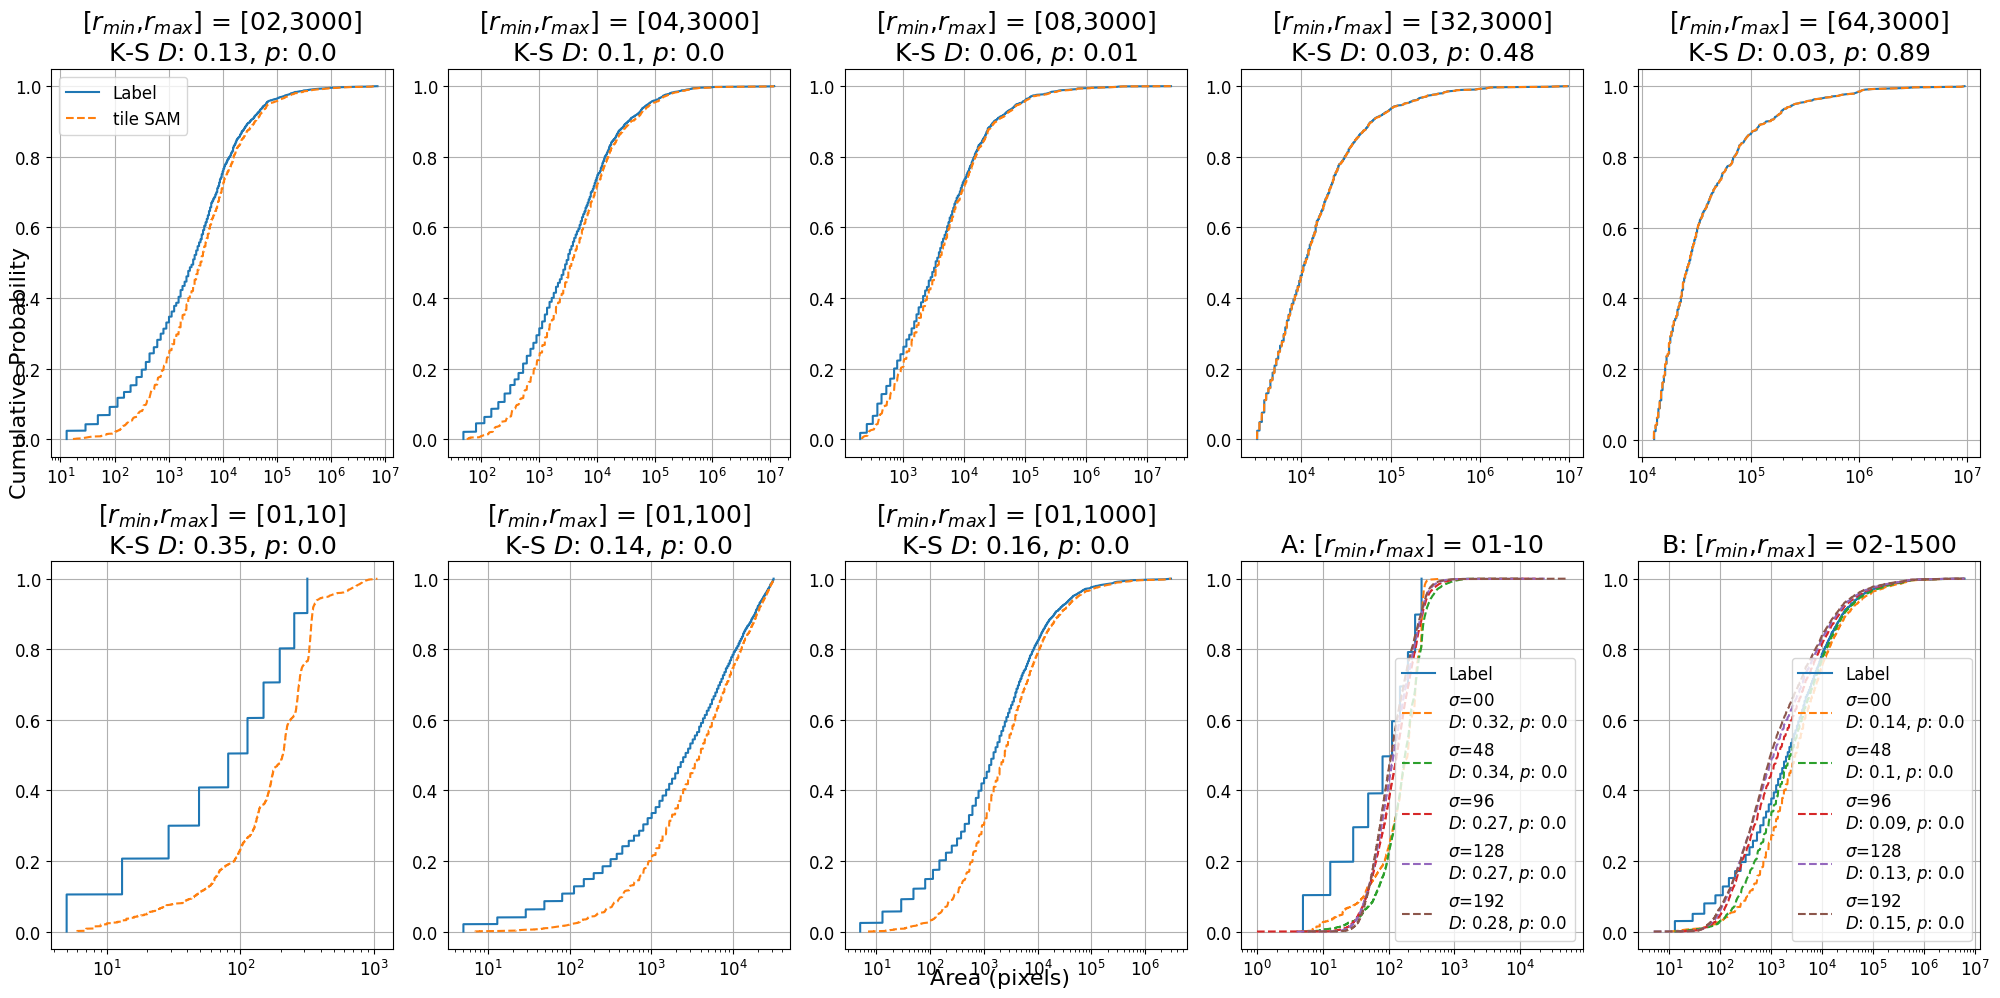

In [184]:
plt.figure(figsize=(20,10))
plt.subplot(2,5,1)
cdf(rs02_3000, r"[$r_{min}$,$r_{max}$] = [02,3000]")
plt.xlabel('')
plt.ylabel('')
plt.legend(fontsize=12)
plt.subplot(2,5,2)
cdf(rs04_3000, r"[$r_{min}$,$r_{max}$] = [04,3000]")
plt.xlabel('')
plt.ylabel('')
plt.subplot(2,5,3)
cdf(rs08, r"[$r_{min}$,$r_{max}$] = [08,3000]")
plt.xlabel('')
plt.ylabel('')
plt.subplot(2,5,4)
cdf(rs32, r"[$r_{min}$,$r_{max}$] = [32,3000]")
plt.xlabel('')
plt.ylabel('')
plt.subplot(2,5,5)
cdf(rs64, r"[$r_{min}$,$r_{max}$] = [64,3000]")
plt.xlabel('')
plt.ylabel('')
plt.subplot(2,5,6)
cdf(rs01_10, r"[$r_{min}$,$r_{max}$] = [01,10]")
plt.xlabel('')
plt.ylabel('')
plt.subplot(2,5,7)
cdf(rs01_100, r"[$r_{min}$,$r_{max}$] = [01,100]")
plt.xlabel('')
plt.ylabel('')
plt.subplot(2,5,8)
cdf(rs01_1000, r"[$r_{min}$,$r_{max}$] = [01,1000]")
plt.ylabel('')
plt.xlabel('')
plt.subplot(2,5,9)
plt.title(r"A: [$r_{min}$,$r_{max}$] = 01-10", fontsize=18)
cdf_cl(cl00_10, r'$\sigma$=00',True)
cdf_cl(cl48_10, r'$\sigma$=48')
cdf_cl(cl96_10, r'$\sigma$=96')
cdf_cl(cl128_10, r'$\sigma$=128')
cdf_cl(cl192_10, r'$\sigma$=192')
plt.legend(fontsize=12)

    
plt.xscale("log")
#plt.xlabel("Area (pixels)", fontsize=16)
#plt.ylabel("Cumulative Probability", fontsize=16) 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)       
plt.grid(True)

plt.subplot(2,5,10)
plt.title(r"B: [$r_{min}$,$r_{max}$] = 02-1500", fontsize=18)
cdf_cl(cl00_02, r'$\sigma$=00',True)
cdf_cl(cl48_02, r'$\sigma$=48')
cdf_cl(cl96_02, r'$\sigma$=96')
cdf_cl(cl128_02, r'$\sigma$=128')
cdf_cl(cl192_02, r'$\sigma$=192')
plt.xscale("log")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)       
plt.grid(True)
#plt.xlabel("Area (pixels)", fontsize=16)
plt.figtext(0.5, 0.01, 'Area (pixels)', ha='center', fontsize=16)
plt.figtext(0.01, 0.5, 'Cumulative Probability', rotation='vertical',ha='center', fontsize=16)
plt.tight_layout()

In [150]:
data1 = np.random.normal(0, 1, 2000) 
data2 = np.random.normal(0, 1, 1000) 
noise1 = np.random.normal(0, 0.5, 2000) 
noise2 = np.random.normal(0, 0.5, 1000)

data1 = data1 + noise1
data2 = data2 + noise2

ks_2samp(data1, data2)

KstestResult(statistic=0.024, pvalue=0.8343251222780397, statistic_location=-1.0718524390165465, statistic_sign=-1)

In [ ]:
sample1 = np.random.choice(data1, size=1000, replace=False)
sample2 = np.random.choice(data2, size=1000, replace=False)
ks_2samp(sample1, sample2)

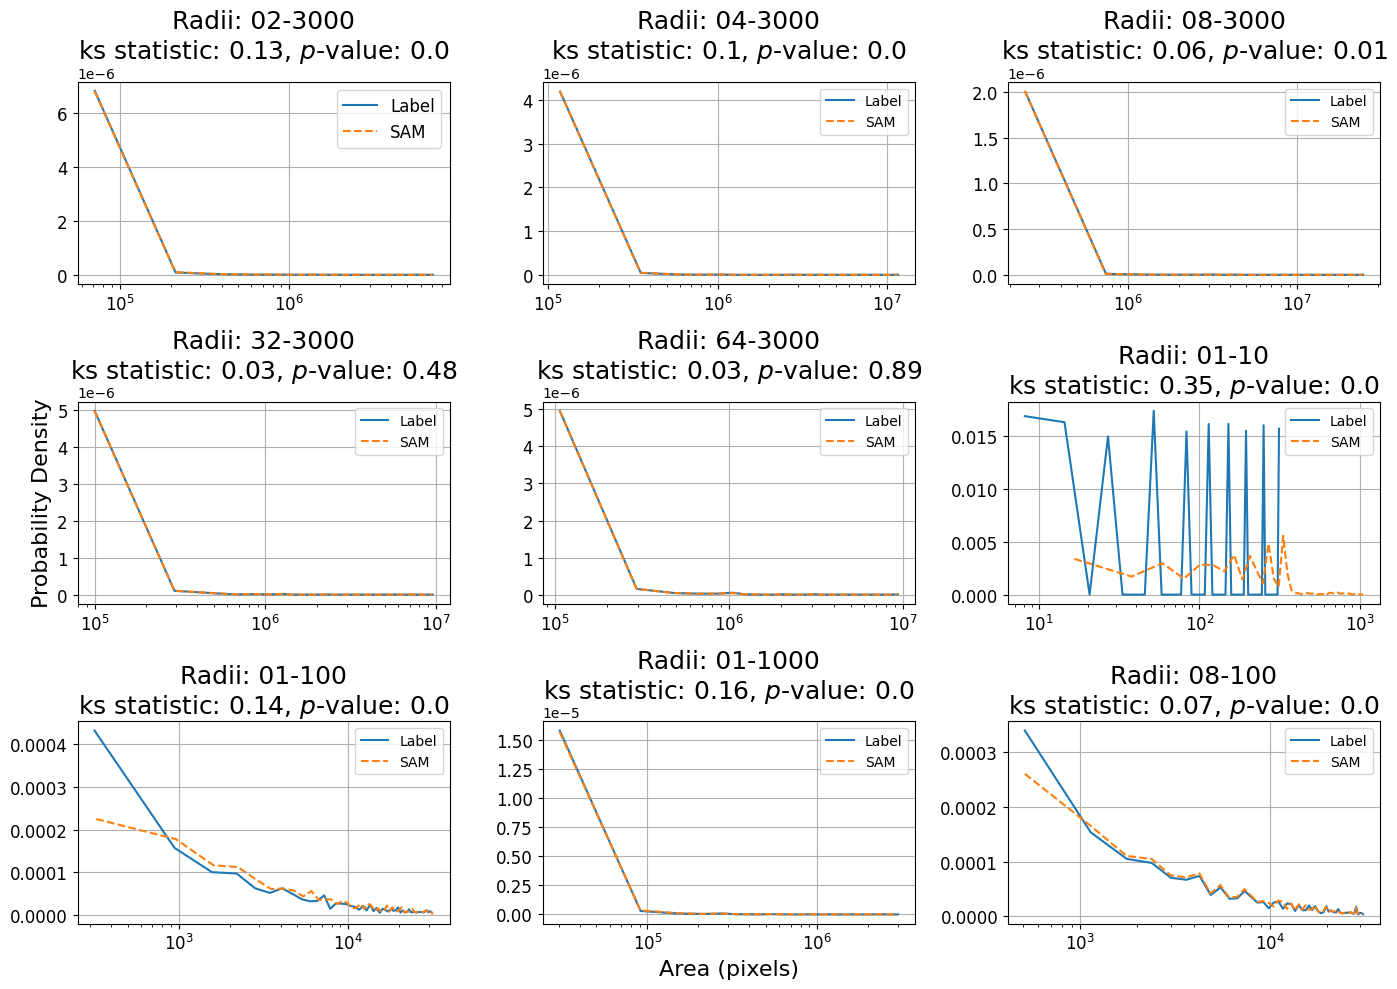

In [111]:
def pdf(DS_pths, title_label, result=True):
    sizes = []
    sizes_re = []
    
    # Collect data
    for pth in DS_pths:
        ran = np.load(pth, allow_pickle=True)
        sizes += list(ran.item().get('area'))
        
        if result:
            sizes_re += list(ran.item().get('segment area'))
    
    # Convert to area per pixel (normalized by 0.2*0.2)
    sizes = np.sort(sizes) / (0.2 * 0.2)
    
    # Calculate histogram (PDF) for sizes
    hist_sizes, bin_edges = np.histogram(sizes, bins=50, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Centers of bins
    
    # Plot the PDF
    plt.plot(bin_centers, hist_sizes, linestyle="-", label='Label')

    if result:
        sizes_re = np.sort(sizes_re)
        hist_sizes_re, bin_edges_re = np.histogram(sizes_re, bins=50, density=True)
        bin_centers_re = (bin_edges_re[:-1] + bin_edges_re[1:]) / 2
        plt.plot(bin_centers_re, hist_sizes_re, linestyle="--", label='SAM')
        
        ks_test = ks_DS(DS_pths)
        plt.title(title_label + '\n' + fr'ks statistic: {np.round(ks_test[0], 2):.2}, $p$-value: {np.round(ks_test[1], 2):.2}', fontsize=18)
    
    # Customize plot
    plt.xscale("log")  # Log scale for x-axis
    plt.xlabel("Area (pixels)", fontsize=16)
    plt.ylabel("Probability Density", fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.legend()

plt.figure(figsize=(14,10))
plt.subplot(3,3,1)
pdf(rs02_3000, "Radii: 02-3000")
plt.xlabel('')
plt.ylabel('')
plt.legend(fontsize=12)
plt.subplot(3,3,2)
pdf(rs04_3000, "Radii: 04-3000")
plt.xlabel('')
plt.ylabel('')
plt.subplot(3,3,3)
pdf(rs08, "Radii: 08-3000")
plt.xlabel('')
plt.ylabel('')
plt.subplot(3,3,4)
pdf(rs32, "Radii: 32-3000")
plt.xlabel('')
plt.subplot(3,3,5)
pdf(rs64, "Radii: 64-3000")
plt.xlabel('')
plt.ylabel('')
plt.subplot(3,3,6)
pdf(rs01_10, "Radii: 01-10")
plt.xlabel('')
plt.ylabel('')
plt.subplot(3,3,7)
pdf(rs01_100, "Radii: 01-100")
plt.xlabel('')
plt.ylabel('')
plt.subplot(3,3,8)
pdf(rs01_1000, "Radii: 01-1000")
plt.ylabel('')
plt.subplot(3,3,9)
pdf(rs08_100, "Radii: 08-100")
plt.xlabel('')
plt.ylabel('')
#plt.suptitle("Size distribution of synthetic scene")
plt.tight_layout()

In [82]:
d=np.load(rs64[0], allow_pickle=True)
area=d.item().get('area')
iou=np.abs(d.item().get('iou'))

#area = np.log10(area)

area=area[iou>0]
iou=iou[iou>0]
meaniou=np.mean(iou)
iou=iou[area>(np.pi*15*15*0.2*0.2)]
if len(iou)>0:
    meaniou_t=np.mean(iou)
else:
    meaniou_t=0
print(f'mean iou: {meaniou}, mean iou t: {meaniou_t}')

mean iou: 0.9908231843863191, mean iou t: 0.9908231843863191


In [80]:
np.max(area)

377399.7200000001

In [93]:
def average_iou(DS_pths):
    d=np.load(DS_pths, allow_pickle=True)
    area=d.item().get('area')
    iou=np.abs(d.item().get('iou'))

    #area = np.log10(area)

    area=area[iou>0]
    iou=iou[iou>0]
    meaniou=np.mean(iou)
    iou=iou[area>(np.pi*15*15/(0.2*0.2))]
    if len(iou)>0:
        meaniou_t=np.mean(iou)
    else:
        meaniou_t=0
    print(f'mean iou: {meaniou}, mean iou t: {meaniou_t}')
    return meaniou
all_mean=[]
for DS in [rs02_3000, rs04_3000,rs08, rs32, rs64,rs01_10, rs01_100, rs01_1000]:
    all_mean.append(average_iou(DS[0]))



mean iou: 0.9743368883604733, mean iou t: 0.9877492718757284
mean iou: 0.9771550402012432, mean iou t: 0.979086638103541
mean iou: 0.9844455508638809, mean iou t: 0.9879137688033965
mean iou: 0.9926668461600806, mean iou t: 0.98932270529384
mean iou: 0.9908231843863191, mean iou t: 0.9861053096769627
mean iou: 0.8124967876027446, mean iou t: 0
mean iou: 0.9779090141381215, mean iou t: 0
mean iou: 0.9689146038065277, mean iou t: 0.9867331797112001


In [94]:
for DS in [cl00_10,  cl03_10, cl12_10, cl24_10,cl48_10, cl96_10, cl128_10, cl192_10]:
    all_mean.append(average_iou(DS[0]))

mean iou: 0.8638792121257158, mean iou t: 0
mean iou: 0.8601638676009191, mean iou t: 0
mean iou: 0.8432786262955774, mean iou t: 0
mean iou: 0.8452085699602436, mean iou t: 0
mean iou: 0.8503094047353585, mean iou t: 0
mean iou: 0.8216728160321863, mean iou t: 0
mean iou: 0.7808399288160086, mean iou t: 0
mean iou: 0.7453111054424278, mean iou t: 0


In [95]:
for DS in [cl00_02, cl03_02, cl12_02, cl24_02, cl48_02, cl96_02, cl128_02, cl192_02]:
    all_mean.append(average_iou(DS[0]))

mean iou: 0.9744921267185049, mean iou t: 0.9846157044527731
mean iou: 0.9753951104622302, mean iou t: 0.9857358563274007
mean iou: 0.9748787106950536, mean iou t: 0.9856846409715427
mean iou: 0.9735005086605253, mean iou t: 0.9863512710637581
mean iou: 0.970306791982565, mean iou t: 0.9859933678746869
mean iou: 0.9584448631156197, mean iou t: 0.9850309028698659
mean iou: 0.9526609899120861, mean iou t: 0.9834083248428855
mean iou: 0.9284966882055983, mean iou t: 0.9604001878849303


In [96]:
np.mean(all_mean)

0.9165661348450005